In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
import seaborn as sns
import importlib
import util
import geopandas as gpd
import plotly.express as px
from util import *
from langdetect import detect
from transformers import pipeline
import statsmodels.api as sm
import nltk
from wordcloud import WordCloud
from PIL import Image

# Content:
[1. Data Preprocessing](##Data-Preprocessing)
- [1.1 Convert txt files into CSV files](###Data-format-conversion)

[2. Data Description](##Data-Description)

- [2.1 Features in 'Ratings' dataset](###Features-in-'Ratings'-dataset)

- [2.2 Features in 'Users' dataset](###Features-in-'Users'-dataset)

- [2.3 Features in 'Breweries' dataset](###Features-in-'Breweries'-dataset)

- [2.4 Features in 'Beers' dataset](###Beer-Styles)

[3. Mathematical Details: K-means](##Mathematical-Details)


[4. Features in beer's name](##Features-in-beer's-name)

- [4.1 Sentiment analysis](###Sentiment-analysis-for-beer's-name)

- [4.2 Indentity the language](###Indentity-the-language-for-beer's-name)

- [4.3 Regress - Beer Name Reflect Beer Flavor](###Regress---Beer-Name-Reflect-Beer-Flavor)


[5. Beer Recommendation System](##Beer-Recommendation-System)

- [5.1 Regional Analysis](###Regional-Analysis)

- [5.2 Keyword analysis](###Keyword-analysis)

## Data Preprocessing

### Data format conversion

In [ ]:
# convert txt files into csv files
def txt_to_csv(filepath, output_file_name):
    print("opening....")
    with open(filepath) as f:
        txt = f.read()
    print("spliting....")
    lis_rating = txt.split('\n\n')
    print("formating....")
    data_list_dict = []
    for item in lis_rating:
        try:
            p = {ii.split(": ")[0]: ii.split(": ")[1] for ii in item.split('\n')}
        except:
            print(item)
            continue
        data_list_dict.append(p)
    print("dataframe....")
    df = pd.DataFrame(data_list_dict)
    print("to csv file.....")
    df.to_csv(output_file_name, sep=',', encoding='utf-8')

    return df

In [ ]:
# read path
fp1 = "./BeerAdvocate/reviews.txt"
fp2 = "./matched_beer_data/ratings_ba.txt"
fp3 = "./matched_beer_data/ratings_rb.txt"
fp4 = "./matched_beer_data/ratings_with_text_ba.txt"
fp5 = "./matched_beer_data/ratings_with_text_rb.txt"
fp6 = "./RateBeer/ratings.txt"
fp7 = "./RateBeer/reviews.txt"

In [ ]:
# write path
ofn1 = "reviews_ba.csv"
ofn2 = "m_ratings_ba.csv"
ofn3 = "m_reviews_rb.csv"
ofn4 = "m_ratings_text_ba.csv"
ofn5 = "m_ratings_text_rb.csv"
ofn6 = "ratings_rb.csv"
ofn7 = "reviews_rb.csv"

We found the data size is too big too handle during our conversion step. Therefore we plan to use matched data from two websites in the following step.

## Data Description

In [2]:
# load the data:
beers = pd.read_csv('data/m_beers.csv')
ratings = pd.read_csv('data/m_ratings.csv')
users = pd.read_csv('data/m_users_approx.csv')
breweries = pd.read_csv('data/m_breweries.csv')

C:\Users\94042\AppData\Local\Temp\ipykernel_529036\2336503227.py:2: DtypeWarning: Columns (0,1,2,3,4,5,8,10,11,12,13,15,16,17,18,19,20,23,25,26,27,29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  beers = pd.read_csv('data/m_beers.csv')
C:\Users\94042\AppData\Local\Temp\ipykernel_529036\2336503227.py:3: DtypeWarning: Columns (0,1,2,3,5,7,8,9,10,11,13,17,18,19,20,22,24,25,26,27,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings = pd.read_csv('data/m_ratings.csv')


In [8]:
#  check and print the number of rows with NaN values
print('nans in ratings:', sum(ratings.isna().any(axis=1)))
print('nans in users:', sum(users.isna().any(axis=1)))
print('nans in beers:', sum(beers.isna().any(axis=1)))
print('nans in breweries:', sum(breweries.isna().any(axis=1)))

nans in ratings: 4026
nans in users: 0
nans in beers: 45043
nans in breweries: 0


We will deal with these nan values later.

In [3]:
beers_rb, beers_ba = split_matched_data(beers)
users_rb, users_ba = split_matched_data(users)
ratings_rb, ratings_ba = split_matched_data(ratings)
breweries_rb, breweries_ba = split_matched_data(breweries)

### Features in 'Ratings' dataset
[back to content](#Content)

In [40]:
ratings_rb[ratings_rb.isna().any(axis=1)]

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,rating,style,taste,text,user_id,user_name


In [5]:
# check the nan values in rating_ba (rating_rb doesn't contain nan value)
ratings_ba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21964 entries, 0 to 21963
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   abv           21964 non-null  object
 1   appearance    19295 non-null  object
 2   aroma         19295 non-null  object
 3   beer_id       21964 non-null  object
 4   beer_name     21964 non-null  object
 5   brewery_id    21964 non-null  object
 6   brewery_name  21964 non-null  object
 7   date          21964 non-null  object
 8   overall       19295 non-null  object
 9   palate        19295 non-null  object
 10  rating        21964 non-null  object
 11  review        21964 non-null  object
 12  style         21964 non-null  object
 13  taste         19295 non-null  object
 14  text          18278 non-null  object
 15  user_id       21964 non-null  object
 16  user_name     21964 non-null  object
dtypes: object(17)
memory usage: 2.8+ MB


- The nan values are all from important features (`overall`, `appearance`, `aroma`, `palate`, etc.) in this data set. So we decided to drop items with nan.

In [4]:
ratings_ba.dropna(inplace=True)
ratings_ba.reset_index(drop=True)

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,rating,review,style,taste,text,user_id,user_name
0,11.3,4.5,4.5,645,Trappistes Rochefort 10,207,Brasserie de Rochefort,1324810800,5.0,4.5,4.8,True,Quadrupel (Quad),5.0,Best before 27.07.2016Directly reviewed in com...,erzengel.248045,Erzengel
1,5.0,3.5,3.5,57911,Cantillon Tyrnilambic Baie D’Argousier Lambic,388,Brasserie Cantillon,1344074400,4.0,4.0,3.85,True,Lambic - Fruit,4.0,"Bottle @ One Pint Pub, Helsinki. 2006 vintage....",tiong.608427,tiong
2,5.0,4.0,3.5,57913,Cantillon Pikkulinnun Viskilambic,388,Brasserie Cantillon,1344074400,4.0,4.0,3.68,True,Lambic - Unblended,3.5,"Originally rated on 16.11.2009, draught @ Pikk...",tiong.608427,tiong
3,6.0,4.0,4.0,81125,Drie Fonteinen Oude Geuze - Armand & Tommy,2216,Brouwerij 3 Fonteinen,1346234400,4.0,4.0,4.0,True,Gueuze,4.0,"750ml bottle, originally rated on 18.8.2012.Bo...",tiong.608427,tiong
4,5.0,4.0,4.0,67932,Cantillon Olutravintola Pikkulintu,388,Brasserie Cantillon,1344074400,4.0,4.5,4.05,True,Lambic - Unblended,4.0,"375ml bottle @ Pikkulintu, Helsinki. Originall...",tiong.608427,tiong
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17933,6.1,4.75,4.5,48720,Native Amber Red IPA,19456,COOP Ale Works,1435917600,4.75,3.75,4.59,True,American Amber / Red Ale,4.75,Deep Amber with nice head retention and lacing...,deezee83.998987,DeeZee83
17934,6.5,4.0,3.5,22048,Vlasbier,634,Brouwerij Van Eecke N.V.,1230548400,1.5,2.0,2.58,True,Belgian Pale Ale,2.5,"This smelled sweet and floral, but the mouthfe...",idler.183543,Idler
17935,9.0,3.5,4.0,4718,Vapeur Cochonne,841,Brasserie à Vapeur,1323860400,4.0,3.5,3.92,True,Belgian Strong Dark Ale,4.0,75cl bottle from Belgian Beer Station. Bottle ...,thebeerwatcher.630107,TheBeerWatcher
17936,8.5,4.5,3.5,28030,Valeir Divers,3463,Brouwerij Contreras,1323946800,4.0,4.0,3.91,True,Tripel,4.0,Valeir Divers 33cl bottle from www.belgianbeer...,thebeerwatcher.630107,TheBeerWatcher


In [5]:
# The type of all the features is 'object'. Convert some of them to float.
convert_features=['abv', 'appearance', 'aroma', 'overall', 'palate', 'rating', 'taste']
ratings_rb[convert_features] = ratings_rb[convert_features].apply(pd.to_numeric, errors = 'coerce')
ratings_ba[convert_features] = ratings_ba[convert_features].apply(pd.to_numeric, errors = 'coerce')

In [8]:
ratings_ba[ratings_ba['abv']>=9]

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,rating,review,style,taste,text,user_id,user_name
0,11.3,4.50,4.50,645,Trappistes Rochefort 10,207,Brasserie de Rochefort,1324810800,5.00,4.50,4.80,True,Quadrupel (Quad),5.00,Best before 27.07.2016Directly reviewed in com...,erzengel.248045,Erzengel
9,12.0,4.00,4.00,76421,Mornin' Delight,23222,Toppling Goliath Brewing Company,1456830000,4.00,4.00,4.00,True,American Double / Imperial Stout,4.00,Draft. Pours oily black with a creamy brown he...,leighton.343447,leighton
10,9.1,4.75,4.75,237682,Beavertown / Boneyard Bloody Notorious,30471,Beavertown Brewery,1467021600,4.75,4.75,4.75,True,American Double / Imperial IPA,4.75,Keg at the brewery. Pours just slightly hazy y...,leighton.343447,leighton
12,10.0,4.25,4.25,175027,Power Of The Voodoo,30471,Beavertown Brewery,1436436000,4.50,4.25,4.40,True,American Double / Imperial IPA,4.50,Can at home in London - sourced from Ales by M...,leighton.343447,leighton
54,9.2,5.00,4.50,250260,Kermis Upgraded 10k,40854,Brouwerij Kwartje,1475056800,4.50,4.75,4.56,True,Russian Imperial Stout,4.50,Draft at Kaapse Borefts After Festival 2016. B...,kermis.705828,kermis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21916,9.1,5.00,4.50,155232,Cool Beans Imperial Coffee Porter,29402,Third Street Brewhouse,1423220400,4.50,4.25,4.51,True,American Porter,4.50,Great coffee aroma. Really nice beer.,jpallinder.939910,jpallinder
21939,11.3,4.00,4.50,645,Trappistes Rochefort 10,207,Brasserie de Rochefort,1091700000,4.50,4.50,4.47,True,Quadrupel (Quad),4.50,This bottle had a best by date of 14Jan08. Pou...,imblane.5525,imblane
21942,11.5,4.00,3.50,7588,Sisyphus,458,Real Ale Brewing Company,1125655200,3.00,3.50,3.43,True,American Barleywine,3.50,"Pours a dull, hazy dark orange, virtually no h...",assurbanipaul.1754,assurbanipaul
21958,9.0,3.50,4.00,4718,Vapeur Cochonne,841,Brasserie à Vapeur,1323860400,4.00,3.50,3.92,True,Belgian Strong Dark Ale,4.00,75cl bottle from Belgian Beer Station. Bottle ...,thebeerwatcher.630107,TheBeerWatcher


In [9]:
ratings_rb[convert_features].describe()

,abv,appearance,aroma,overall,palate,rating,taste
count,21964.000000,21964.000000,21964.000000,21964.000000,21964.000000,21964.000000,21964.000000
mean,6.800216,3.685986,6.960344,14.401657,3.535057,3.558824,7.005190
std,2.096192,0.677436,1.355669,2.677514,0.733544,0.585348,1.384695
min,0.500000,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000
25%,5.200000,3.000000,6.000000,13.000000,3.000000,3.300000,6.000000
50%,6.400000,4.000000,7.000000,15.000000,4.000000,3.600000,7.000000
75%,8.000000,4.000000,8.000000,16.000000,4.000000,4.000000,8.000000
max,39.000000,5.000000,10.000000,20.000000,5.000000,5.000000,10.000000


In [10]:
ratings_ba[convert_features].describe()

,abv,appearance,aroma,overall,palate,rating,taste
count,17938.000000,17938.000000,17938.000000,17938.000000,17938.000000,17938.000000,17938.000000
mean,6.804901,3.794222,3.705277,3.734028,3.687061,3.719170,3.714893
std,2.104107,0.566788,0.607502,0.624533,0.626139,0.556847,0.632683
min,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5.200000,3.500000,3.500000,3.500000,3.500000,3.450000,3.500000
50%,6.400000,4.000000,3.750000,4.000000,3.750000,3.780000,3.750000
75%,8.000000,4.000000,4.000000,4.000000,4.000000,4.080000,4.000000
max,39.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [6]:
# scaling th features
ratings_rb_with_convert_features = ratings_rb[convert_features]
ratings_ba_with_convert_features = ratings_ba[convert_features]
ratings_rb[convert_features] = (
    ratings_rb_with_convert_features - ratings_rb_with_convert_features.min()
) / (ratings_rb_with_convert_features.max() - ratings_rb_with_convert_features.min())
ratings_ba[convert_features] = (
    ratings_ba_with_convert_features - ratings_ba_with_convert_features.min()
) / (ratings_ba_with_convert_features.max() - ratings_ba_with_convert_features.min())

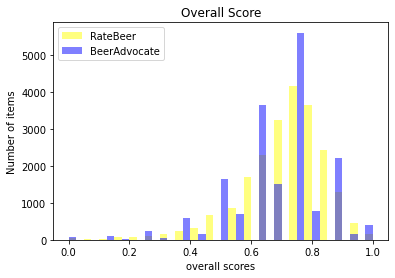

In [12]:
# plot the histgram of the overall score from two websites respectively
plt.hist(ratings_rb['overall'], bins=40, alpha = 0.5, label = 'RateBeer', color='yellow')
plt.hist(ratings_ba['overall'], bins=40, alpha = 0.5, label = 'BeerAdvocate', color='blue')

plt.xlabel('overall scores')
plt.ylabel('Number of items')
plt.title('Overall Score')
plt.legend()

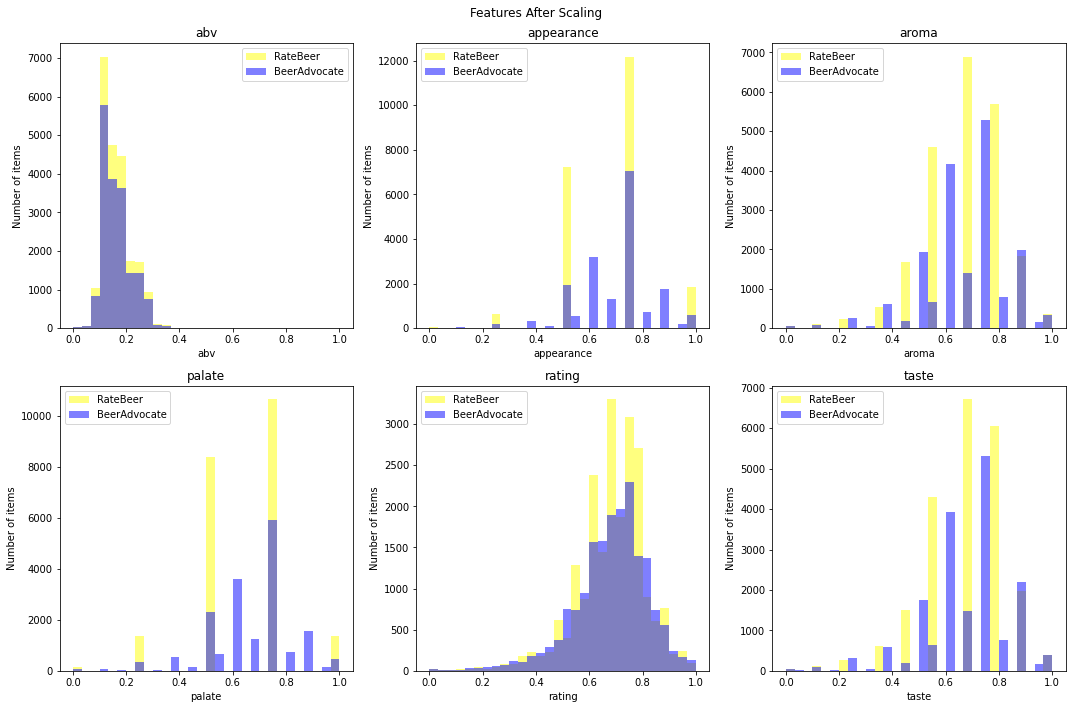

In [13]:
# plot the histgram of other features from the two websites
rows = 2
cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

i = 0
for feature in convert_features:
    if feature != 'overall':
        ax = axs[i//cols][i%cols]
        ax.hist(ratings_rb[feature], bins=30, alpha = 0.5, label = 'RateBeer', color='yellow')
        ax.hist(ratings_ba[feature], bins=30, alpha = 0.5, label = 'BeerAdvocate', color='blue')
        ax.set_xlabel(feature)
        ax.set_ylabel('Number of items')
        ax.set_title(feature)
        ax.legend()
        i += 1
        
plt.suptitle('Features After Scaling')
fig.tight_layout()
plt.show()

We found the distribution between 'appearance' and 'palate'; 'taste' and 'aroma' are really similar. So then we'll try to explore the connection across the features.

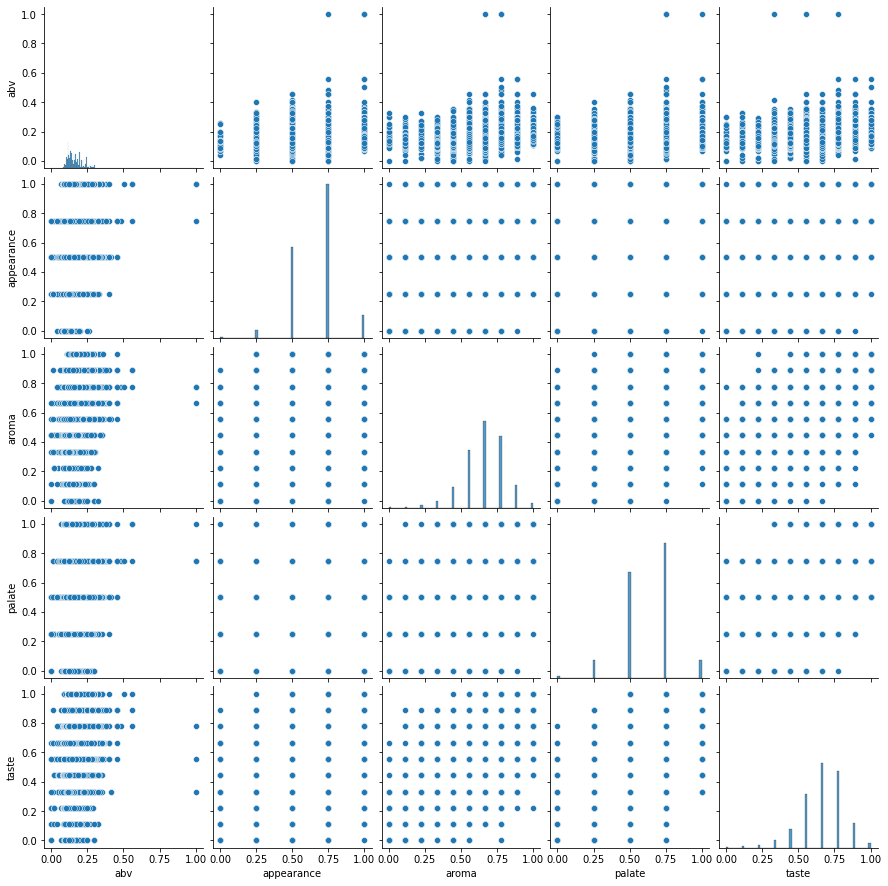

In [14]:
detailed_features = ['abv', 'appearance', 'aroma', 'palate', 'taste']
sns.pairplot(ratings_rb[detailed_features])
plt.show()

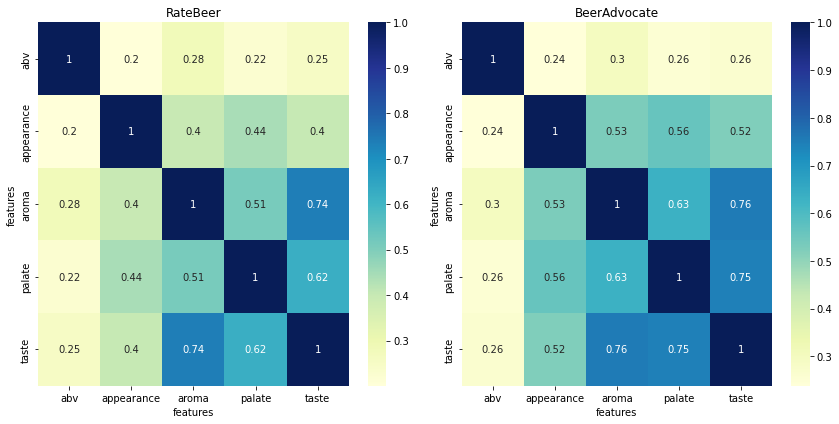

In [15]:
# heat map for different features:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(ratings_rb[detailed_features].corr(), ax = axs[0], annot=True, cmap='YlGnBu', cbar=True)
sns.heatmap(ratings_ba[detailed_features].corr(), ax = axs[1], annot=True, cmap='YlGnBu', cbar=True)
axs[0].set_title('RateBeer')
axs[0].set_xlabel('features')
axs[0].set_ylabel('features')

axs[1].set_title('BeerAdvocate')
axs[1].set_xlabel('features')
axs[1].set_ylabel('features')
fig.tight_layout()
plt.show()


There are some strong linear connections between features. These can be discussed in details in our further work.

In [16]:
# try regression model on features and overall ratings
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split

model = RidgeCV(alphas=[0.01, 0.05, 0.1])
X_train, X_test, y_train, y_test = train_test_split(
    ratings_ba[detailed_features], ratings_ba["overall"], test_size=0.2, random_state=42
)

In [17]:
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7657120104463955

In [18]:
# check the contribution of each coefficient
sorted_coef_pairs = sorted(
    zip(model.coef_, detailed_features), key=lambda x: abs(x[0]), reverse=True
)
sorted_coefs = [pair[0] for pair in sorted_coef_pairs]
sorted_features = [pair[1] for pair in sorted_coef_pairs]

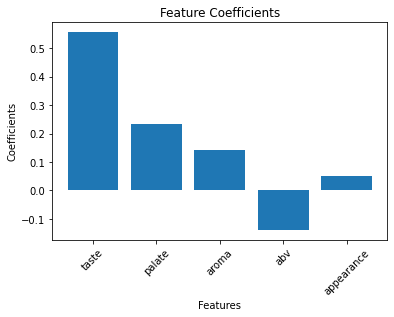

In [19]:
plt.figure(figsize=(6, 4))  # You can adjust the figure size as needed
plt.bar(sorted_features, sorted_coefs)

# Adding labels and title
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Feature Coefficients')
plt.xticks(rotation=45)  # Rotates feature names for better readability

plt.show()

### Features in 'Users' dataset
[back to content](#Content)

In [7]:
users_loc_ba = users_ba.groupby('location').size()
users_loc_rb = users_rb.groupby('location').size()

In [13]:
# check if users' locations from the two websites are different
False in users_loc_ba == users_loc_rb

False

Notice that 'location' counts states for US users and countries only for other users, so break the data down into US users and non-US users. Since the dataset is matched, we only need to discuss the loaction distribution of one website.

In [8]:
# splite the US and non-US users
users_loc_ba_US = users_loc_ba[users_loc_ba.index.str.contains('United States')]
users_loc_ba_nonUS = users_loc_ba[~users_loc_ba.index.str.contains('United States')]

In [25]:
sum(users_loc_ba_US)

2683

In [26]:
sum(users_loc_ba_nonUS)

658

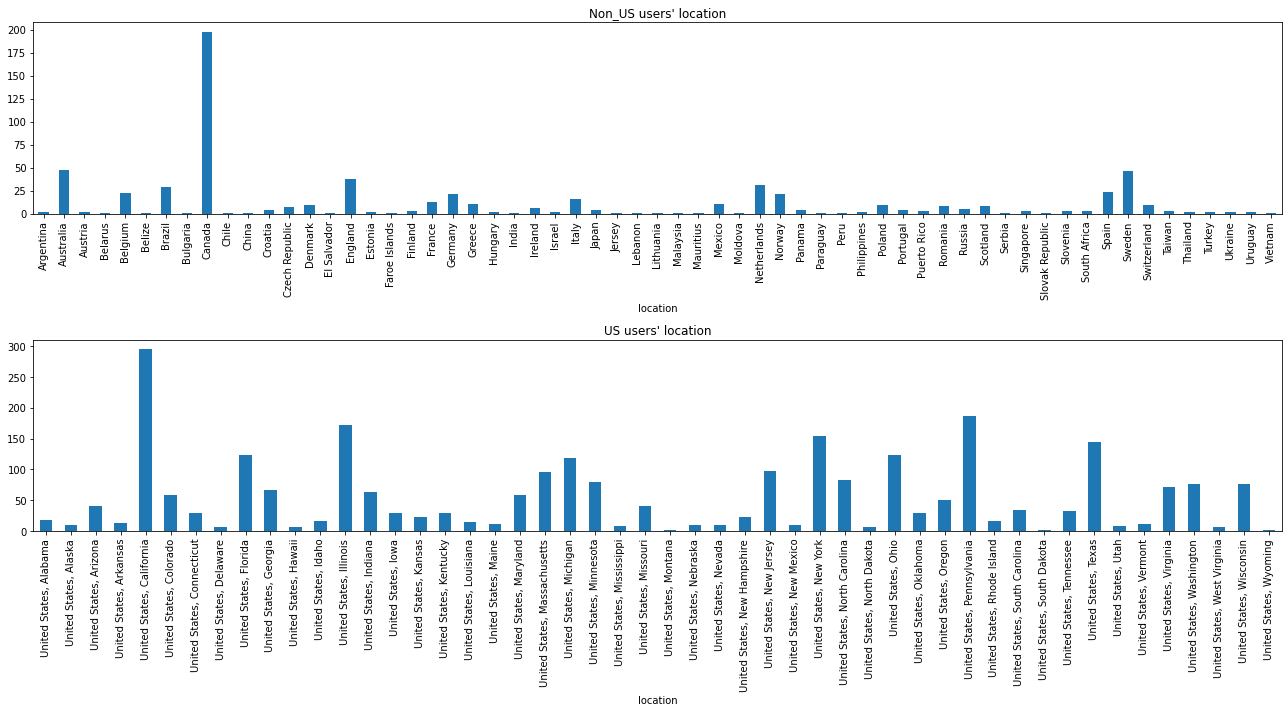

In [23]:
# plot the result
fig, axs = plt.subplots(2, 1, figsize = (18, 10))
users_loc_ba_nonUS.plot(kind = 'bar', ax = axs[0])
users_loc_ba_US.plot(kind = 'bar', ax = axs[1])

axs[0].set_title("Non_US users' location")
axs[1].set_title("US users' location")

fig.tight_layout()
plt.show()

There are far more users in the United States than in other countries, which will be taken into account in our subsequent work.

### Features in 'Breweries' dataset
[back to content](#Content)

In [14]:
# group breweries data by locations
breweries_loc_rb = breweries_rb.groupby('location').size()
breweries_loc_ba = breweries_ba.groupby('location').size()

In [15]:
# check if breweries' locations from the two websites are different
False in breweries_loc_rb == breweries_loc_ba

False

In [16]:
# splite the US and non_US locations
breweries_loc_ba_US = breweries_loc_ba[
    breweries_loc_ba.index.str.contains("United States", "U.S.")
    | breweries_loc_ba.index.str.contains("U.S.")
]
breweries_loc_ba_nonUS = breweries_loc_ba[
    ~(
        breweries_loc_ba.index.str.contains("United States", "U.S.")
        | breweries_loc_ba.index.str.contains("U.S.")
    )
]

In [34]:
sum(breweries_loc_ba_nonUS)

4323

In [35]:
sum(breweries_loc_ba_US)

3958

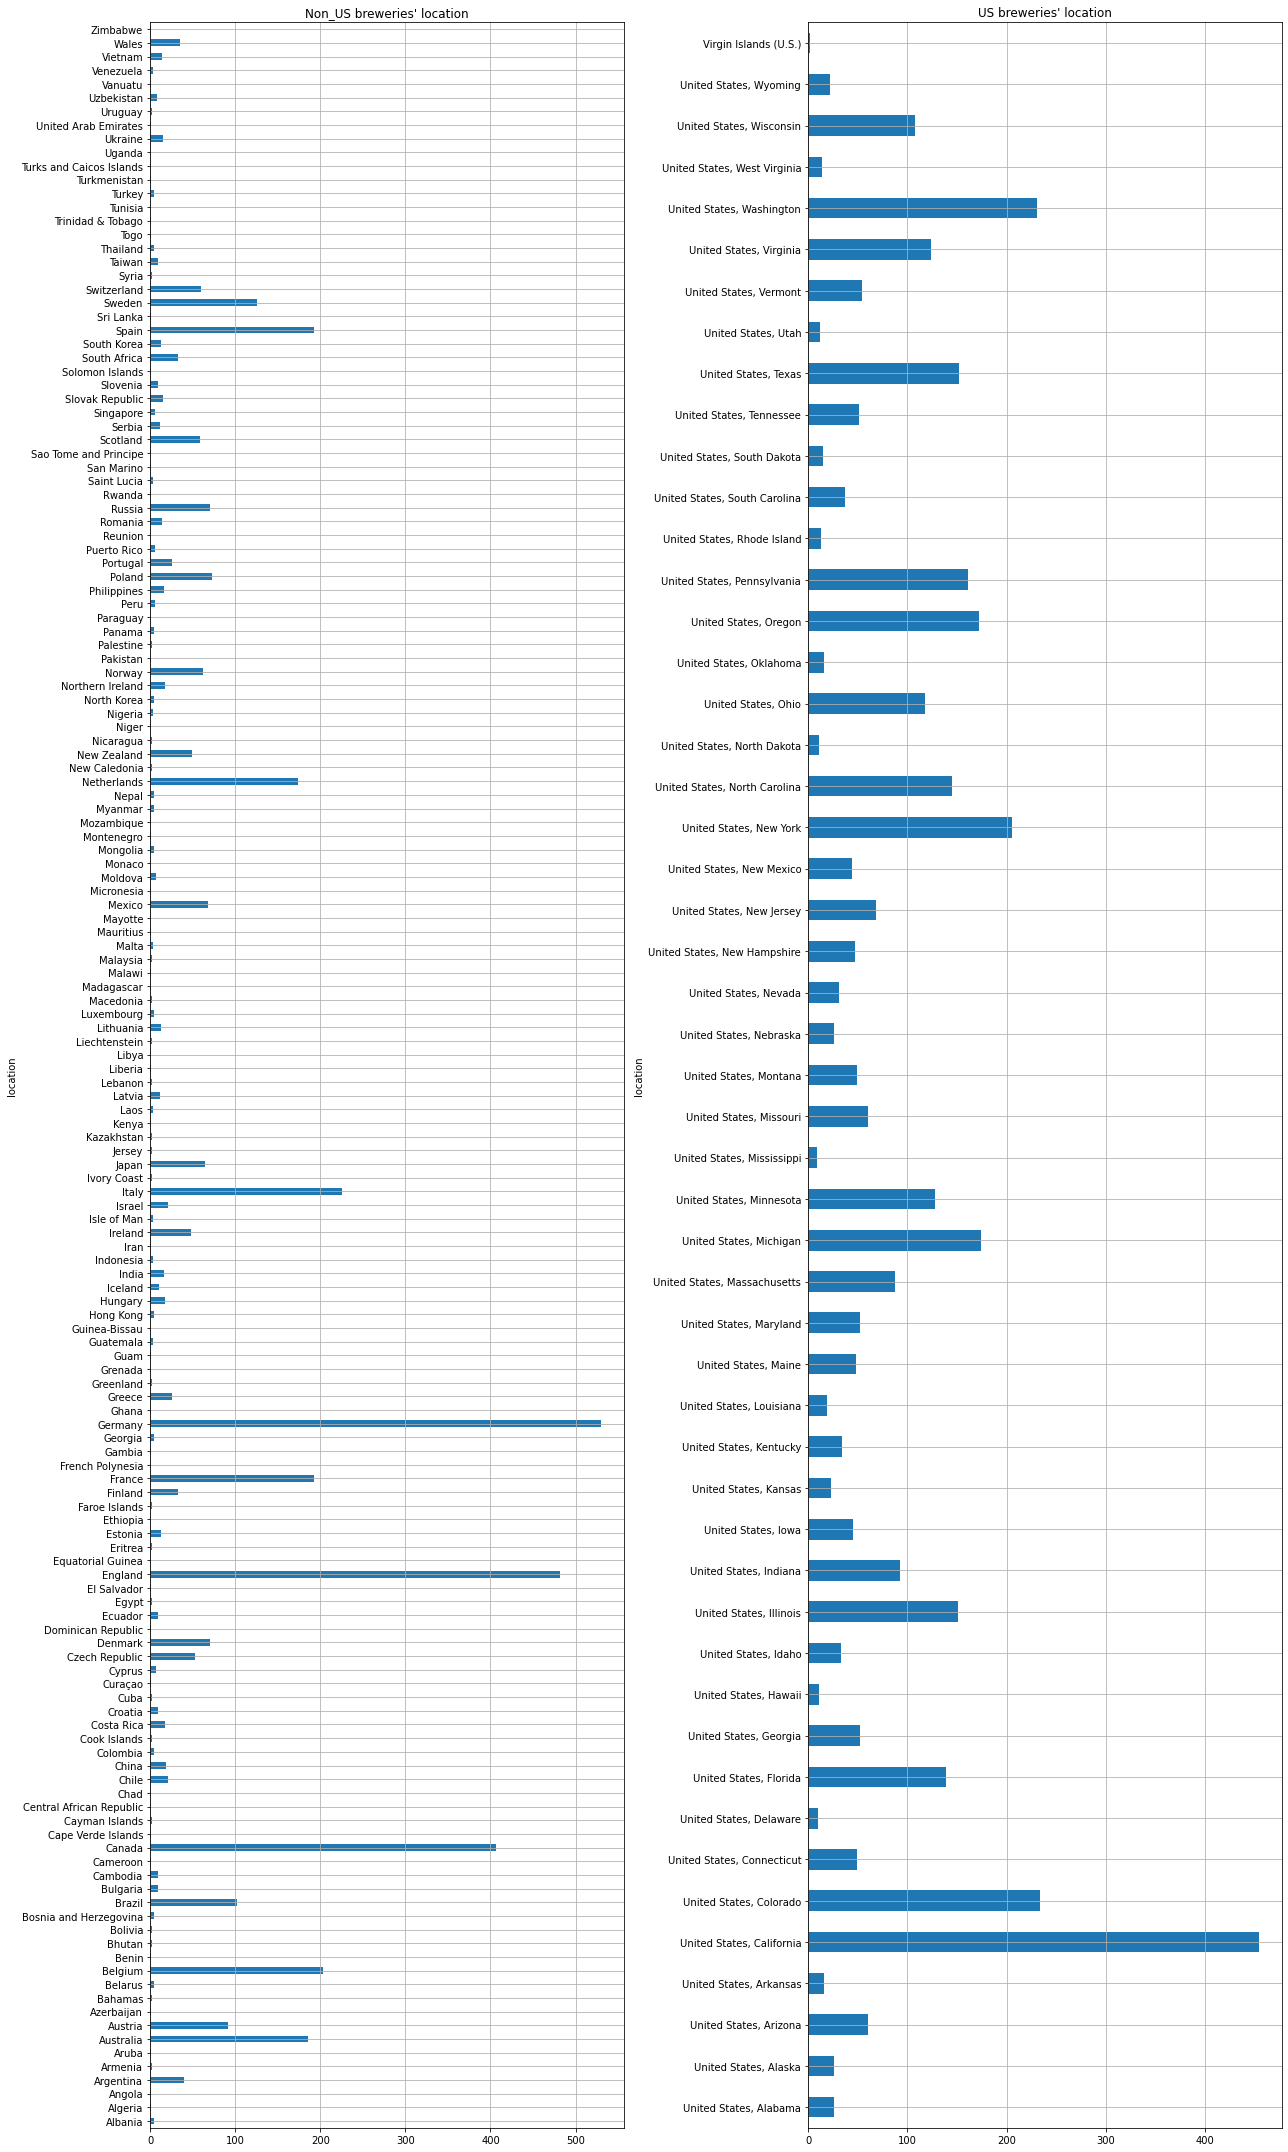

In [32]:
fig, axs = plt.subplots(1, 2, figsize = (18, 30))
breweries_loc_ba_nonUS.plot(kind = 'barh', ax = axs[0], grid=True)
breweries_loc_ba_US.plot(kind = 'barh', ax = axs[1], grid=True)

axs[0].set_title("Non_US breweries' location")
axs[1].set_title("US breweries' location")

fig.tight_layout()
plt.show()

### Beer Styles
[back to content](#Content)

In [187]:
beers_ba.columns

Index(['abv', 'avg', 'avg_computed', 'avg_matched_valid_ratings', 'ba_score',
       'beer_id', 'beer_name', 'beer_wout_brewery_name', 'brewery_id',
       'brewery_name', 'bros_score', 'nbr_matched_valid_ratings',
       'nbr_ratings', 'nbr_reviews', 'style', 'zscore'],
      dtype='object', name=0)

In [18]:
style_counts = beers_ba['style'].value_counts()

In [19]:
style_percentages = style_counts / style_counts.sum() * 100
100-sum(style_percentages[:12])

49.971516213847494

In [20]:
beers_style = list(set(beers_ba['style']))

In [4]:
# get beers style description by crawling
import requests
from bs4 import BeautifulSoup
import csv

# The base URL of the beer style guidelines
url = 'https://www.brewersassociation.org/edu/brewers-association-beer-style-guidelines/'
# CSV file where the data will be saved
csv_file = '/data/beer_styles_descriptions.csv'
# Define headers to simulate a browser visit
headers = {
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:88.0) Gecko/20100101 Firefox/88.0'
}

In [5]:
# Send a GET request to the website
response = requests.get(url, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    # Parse the content of the request with BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the section containing the beer styles
    beer_styles_section = soup.find('section', id='beer-styles')
    
    # Find all individual beer style entries within that section
    beer_styles = beer_styles_section.find_all('div', class_='beer-style')
    
    # Prepare a list to hold all the scraped data
    beer_style_data = []
    
    # Loop over each beer style and extract the data
    for beer_style in beer_styles:
        # Find the name of the beer style
        style_name = beer_style.find('li').text.strip()
        
        # Find all the characteristics of the beer style
        characteristics = beer_style.find_all('li')[1:]  # Skip the first li as it's the name
        
        # Prepare a dictionary to hold the data for this beer style
        style_data = {
            'Style Name': style_name,
            'Characteristics': ' | '.join([char.text.strip() for char in characteristics])
        }
        
        # Add the dictionary to our list of all data
        beer_style_data.append(style_data)
    
    # Specify the filename to write to
    csv_filename = './data/beer_styles_bab.csv'
    
    # Writing the data to a CSV file
    with open(csv_filename, mode='w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=['Style Name', 'Characteristics'])
        writer.writeheader()
        for data in beer_style_data:
            writer.writerow(data)
    
    print(f"Data scraped and saved to {csv_filename}")
else:
    print(f"Failed to retrieve the webpage. Status code: {response.status_code}")

Data scraped and saved to ./data/beer_styles_bab.csv


In [7]:
# Create a DataFrame with the example text as a column
df = pd.read_csv('./data/beer_styles_bab.csv')
df.columns = ['style', 'characteristics']
# Split the 'Characteristics' column into multiple columns at the '|'
# First, separate the characteristics into individual items
def extract_elements(row):
    elements = row.split(' | ')
    first_eight = elements[:7] if len(elements) >= 8 else elements + [None] * (8 - len(elements))
    last_three = elements[-3:] if len(elements) >= 3 else [None] * (3 - len(elements))
    return first_eight + last_three

df_characteristics = pd.DataFrame(df['characteristics'].apply(extract_elements).tolist())

# Create a new DataFrame to hold the processed columns
df_split = pd.DataFrame()
df_split['style_name'] = df['style']

import re
def extract_second_parenthesis(text):
    matches = re.findall(r'\(([^)]*)\)', text)
    return matches[1] if len(matches) > 1 else 'varies'

def extract_numeric_range(text):
    # Regular expression to match a numeric range
    match = re.search(r'\d+-\d+', text)
    # Return the matched string if found, else None
    return match.group() if match else 'varies'

def extract_second_parenthesis_2(text):
    # Find all patterns within parentheses
    matches = re.findall(r'\(([^)]*)\)', text)
    # Extract the second match, and remove any non-numeric characters except for '-' and '+'
    return re.sub(r'[^\d\-\+]', '', matches[1]) if len(matches) > 1 else 'varies'

# Iterate over the separated items to further split and get a key:value format
for i in range(len(df_characteristics.columns)):
    # Split each item into a key and value at the first ':'
    if i <= 6:
        df_split_temp = df_characteristics[i].str.split(': ', n=1, expand=True)
        df_split[df_split_temp[0].iloc[0]] = df_split_temp[1]
    elif i == 7:
        df_split_temp = df_characteristics[i].apply(extract_second_parenthesis)
        df_split['Alcohol'] = df_split_temp
    elif i == 8:
        df_split_temp = df_characteristics[i].apply(extract_numeric_range)
        df_split['Bitterness_IBU'] = df_split_temp
    elif i == 9:
        df_split_temp = df_characteristics[i].apply(extract_second_parenthesis_2)
        df_split['Color_SRM'] = df_split_temp

df_split.head()

,style_name,Color,Clarity,Perceived Malt Aroma & Flavor,Perceived Hop Aroma & Flavor,Perceived Bitterness,Fermentation Characteristics,Body,Alcohol,Bitterness_IBU,Color_SRM
0,Ordinary Bitter,Gold to copper-colored,Chill haze is allowable at cold temperatures,Low to medium residual malt sweetness should b...,Very low to medium-low,Medium,Mild carbonation traditionally characterizes d...,Low to medium,3.00%-4.20%,20-35,10-24
1,Special Bitter or Best Bitter,Deep gold to deep copper,Chill haze is acceptable at low temperatures,Medium residual malt sweetness should be present,Very low to medium at the brewer’s discretion,Medium and not harsh,Low carbonation traditionally characterizes dr...,Medium,4.20%-4.80%,28-40,12-28
2,Extra Special Bitter,Amber to deep copper,Chill haze is acceptable at low temperatures,Medium to medium-high,Medium to medium-high,Medium to medium-high,Low carbonation traditionally characterizes dr...,Medium,4.80%-5.80%,30-45,16-34
3,Scottish-Style Light Ale,Gold to light brown,Chill haze is acceptable at low temperatures,"Malty, caramel aroma may be present. A low to ...",Should not be present,Low,Yeast attributes such as diacetyl and sulfur a...,Low,2.80%-3.50%,9-20,12-30
4,Scottish-Style Heavy Ale,Amber to dark brown,Chill haze is acceptable at low temperatures,"Malty, caramel aroma is present. The style exh...",Should not be present,Perceptible but low,Yeast attributes such as diacetyl and sulfur a...,Medium with a soft chewy character,3.50%-4.10%,12-20,16-60


In [8]:
df_split.to_csv('data/beer_styles_bab.csv')

## Mathematical Details
[back to content](#Content)

### K-means
K-means can be considered an optimization problem
$$
\begin{align*}
C^*=\mathrm{arg} \min\limits_{C} W(C)=
\mathrm{arg} \min\limits_{C}\sum_{l=1}^{k}\sum_{C(i)=l} d(x_i, m_j)
\end{align*}
$$
This is to solve the best clustering $C^*$ such that the sum of the distance between the data point and the centroids/clustroid of its cluster is minimized under the selected metric. $d(x_i, m_j)$ is the distance between $x_i$ and the centroid/centroid $m_j$ of cluster $C_j$.

Suppose we use the squared Euclidean distance $d(x_i, m_j) = ||x_i-m_l||^2$ . After initializing the cluster centroids $m_1, m_2, \cdots, m_k$, the algorithm is solved by two steps:

1. **Find the nearest cluster for each data point and assign them to the corresponding cluster**. 

   Find $C^*$ s.t.  $C^* = \mathrm{arg} \min\limits_{C}\sum\limits_{l=1}^{k}\sum\limits_{C(i)=l} ||x_i-m_l||^2$ for the given $m_1,m_2,... m_l$.

2. **Update the cluster centroid of each cluster.** 

   For current $C$, recompute $m_l=\frac{1}{|C_l|}\sum\limits_{C(i)=l}x_i$ for $l = 1, \cdots k$.	

Alternate these two steps until the stop criterion.

## Features in beer's name
[back to content](#Content)

In [188]:
# merge ratings_rb and beers_rb to get beer_without_brewery_name
ratings_rb_name = ratings_rb.merge(beers_rb[['beer_name','beer_wout_brewery_name']], on ="beer_name" ,how = "left")
# ratings_rb_name['beer_wout_brewery_name'].fillna(ratings_rb_withid['beer_name'], inplace=True)
ratings_rb_name['beer_wout_brewery_name'].fillna(ratings_rb_name['beer_name'], inplace=True)
ratings_ba_name = ratings_ba.merge(beers_ba[['beer_name','beer_wout_brewery_name']], on ="beer_name" ,how = "left")
# ratings_ba_name['beer_wout_brewery_name'].fillna(ratings_ba_withid['beer_name'], inplace=True)
ratings_ba_name['beer_wout_brewery_name'].fillna(ratings_ba_name['beer_name'], inplace=True)

### Sentiment analysis for beer's name
[back to content](#Content)

Beer names come in a wide range of styles, from straightforward descriptions like "Co-op Wheat Beer" to creatively evocative ones like "Just Married" or "Pheasantry Dancing Dragonfly".

We score it with variable $𝑁𝑎𝑚𝑒𝑆𝑒𝑛𝑡𝑖𝑚𝑒𝑛𝑡$ expressing whether the bear's name is positive or negative, and to what extent it is, using an NLP model for sentiment analysis.

Here we use pipeline (transformers package) and distilbert-base-uncased-finetuned-sst-2-english model.

In [41]:
# for RB data
# Load pre-trained sentiment analysis model
sentiment_analyzer = pipeline('sentiment-analysis')
beer_names = ratings_rb_name['beer_wout_brewery_name']

# Function to perform sentiment analysis on a text
def analyze_sentiment(text):
    result = sentiment_analyzer(text)
    return result[0]['label'], result[0]['score']

# Create new columns 'sentiment' and 'sentiment_score' 
ratings_rb_name[['sentiment', 'sentiment_score']] = ratings_rb_name['beer_wout_brewery_name'].apply(analyze_sentiment).apply(pd.Series)

# Display the DataFrame with sentiment analysis results
print(ratings_rb_name[['beer_wout_brewery_name', 'sentiment', 'sentiment_score']])


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

C:\Users\94042\AppData\Roaming\Python\Python39\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\94042\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


(…)glish/resolve/main/tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

(…)ned-sst-2-english/resolve/main/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

0            beer_wout_brewery_name sentiment  sentiment_score
0                     Trappistes 10  NEGATIVE         0.816014
1                        Beer Lager  NEGATIVE         0.997743
2      dArgousier Baie Tyrnilambic  NEGATIVE         0.995334
3           Viskilambic Pikkulinnun  NEGATIVE         0.955743
4           Oude Geuze Armand Tommy  NEGATIVE         0.688414
...                             ...       ...              ...
21959                 Divers Valeir  POSITIVE         0.929415
21960                        Saison  NEGATIVE         0.854666
21961                       Jupiler  NEGATIVE         0.588483
21962     dOude Maalderij Redenaar  POSITIVE         0.705880
21963       Damnation III Mes Black  NEGATIVE         0.997812

[21964 rows x 3 columns]


In [42]:
# for BA data
sentiment_analyzer = pipeline('sentiment-analysis')
beer_namesba= ratings_ba_name['beer_wout_brewery_name']

# Function to perform sentiment analysis on a text
def analyze_sentiment(text):
    result = sentiment_analyzer(text)
    return result[0]['label'], result[0]['score']

# Create new columns 'sentiment' and 'sentiment_score'
ratings_ba_name[['sentiment', 'sentiment_score']] = ratings_ba_name['beer_wout_brewery_name'].apply(analyze_sentiment).apply(pd.Series)

# Display the DataFrame with sentiment analysis results
print(ratings_ba_name[['beer_wout_brewery_name', 'sentiment', 'sentiment_score']])

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


0                   beer_wout_brewery_name sentiment  sentiment_score
0                            Trappistes 10  NEGATIVE         0.816014
1      Baie Tyrnilambic D’Argousier Lambic  NEGATIVE         0.988593
2                  Viskilambic Pikkulinnun  NEGATIVE         0.955743
3             Oude Geuze Armand Tommy Drie  NEGATIVE         0.784848
4                 Olutravintola Pikkulintu  POSITIVE         0.648327
...                                    ...       ...              ...
33446                 Native Amber Red IPA  POSITIVE         0.972078
33447                             Vlasbier  POSITIVE         0.895688
33448                             Cochonne  POSITIVE         0.682051
33449                        Divers Valeir  POSITIVE         0.929415
33450              Damnation III Mes Black  NEGATIVE         0.997812

[33451 rows x 3 columns]


The "sentiment_score" represents a numerical value that indicates the confidence or strength of the sentiment prediction for a given text. Here $ 0 <SentimentScore \leq 1$.
Let 
$$ NameSentiment = \begin{cases}
SentimentScore & sentiment \quad is \quad "positive"\\
-SentimentScore & sentiment \quad is \quad "negative"
\end{cases}$$

In [43]:
# NameSentiment is in [0,1] if POSITIVE; = is in [-1,0] if negative
# for RB data
ratings_rb_name['NameSentiment'] = np.where(ratings_rb_name['sentiment'] == 'POSITIVE', 
                                                   ratings_rb_name['sentiment_score'], 
                                                   -ratings_rb_name['sentiment_score'])

In [44]:
# for BA data
ratings_ba_name['NameSentiment'] = np.where(ratings_ba_name['sentiment'] == 'POSITIVE', 
                                                   ratings_ba_name['sentiment_score'], 
                                                   -ratings_ba_name['sentiment_score'])

### Indentity the language for beer's name
[back to content](#Content)

The beers' names vary not only in style but also in the language they are presented in, from English to Finnish, Hungarian, and more.

Here we try to identity the language using langdetect.

In [47]:
ratings_rb_withid_lang = ratings_rb_name.copy()
ratings_ba_withid_lang = ratings_ba_name.copy()

In [48]:
# list of beer names
beer_names = ratings_rb_withid_lang['beer_wout_brewery_name']

# Function to detect language of a text
def detect_language(text):
    try:
        lang = detect(text)
        return lang
    except:
        # Handle cases where language detection fails
        return "unknown"

    
# Create a new column 'language'
# for RB data
ratings_rb_withid_lang['language'] = ratings_rb_withid_lang['beer_wout_brewery_name'].apply(detect_language)

In [49]:
# for BA data
beer_names = ratings_ba_withid_lang['beer_wout_brewery_name']
ratings_ba_withid_lang['language'] = ratings_ba_withid_lang['beer_wout_brewery_name'].apply(detect_language)

### Plot for the sentiment and language of beer's name

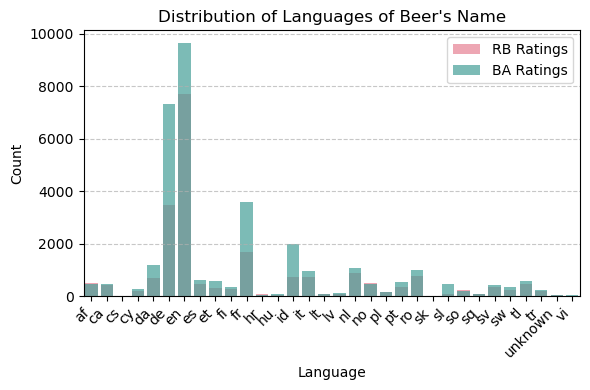

In [50]:
# Count the occurrences of each language in both datasets
rb_language_counts = ratings_rb_withid_lang['language'].value_counts()
ba_language_counts = ratings_ba_withid_lang['language'].value_counts()

# Create a DataFrame to combine the counts
language_df = pd.DataFrame({'RB Ratings': rb_language_counts, 'BA Ratings': ba_language_counts}).fillna(0)

# Set a color palette with distinct colors for each category
colors = sns.color_palette("husl", 2)

# Plotting the bar plot with seaborn for better styling
plt.figure(figsize=(6, 4))
sns.barplot(x=language_df.index, y='RB Ratings', data=language_df, label='RB Ratings', color=colors[0], alpha=0.7)
sns.barplot(x=language_df.index, y='BA Ratings', data=language_df, label='BA Ratings', color=colors[1], alpha=0.7)

# Adding labels and title
plt.xlabel('Language')
plt.ylabel('Count')
plt.title('Distribution of Languages of Beer\'s Name')

# Adding legend
plt.legend()

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adding grid for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

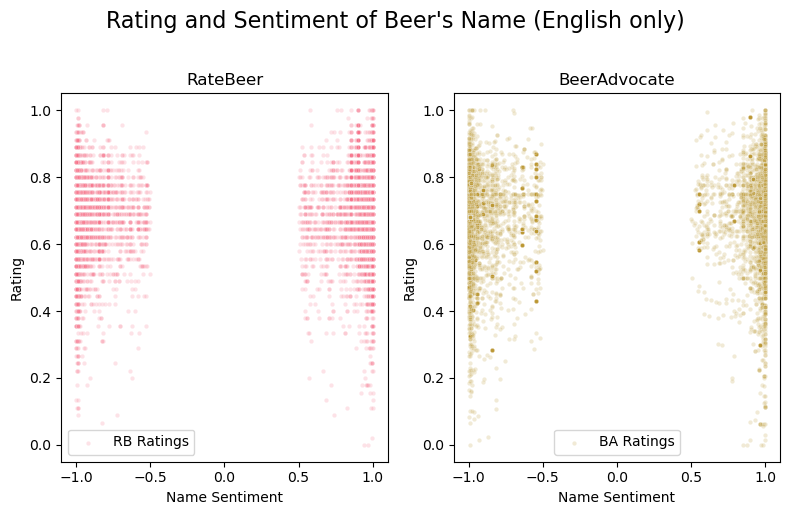

In [9]:
ratings_rb_withid1= ratings_rb_withid_lang[ratings_rb_withid_lang['language'] == "en"]
ratings_ba_withid1= ratings_ba_withid_lang[ratings_ba_withid_lang['language'] == "en"]

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(8,  5))  # 1 row, 2 columns

# Set a color palette
colors = sns.color_palette("husl")

# Plotting the first set of data (ratings_rb_withid1) in the first subplot
axes[0].scatter(ratings_rb_withid1['NameSentiment'], ratings_rb_withid1['rating'], label='RB Ratings', alpha=0.2, s=10, color=colors[0], edgecolor='w', linewidth=0.5)
axes[0].set_xlabel('Name Sentiment')
axes[0].set_ylabel('Rating')
axes[0].set_title('RateBeer')
axes[0].legend()

# Plotting the second set of data (ratings_ba_withid1) in the second subplot
axes[1].scatter(ratings_ba_withid1['NameSentiment'], ratings_ba_withid1['rating'], label='BA Ratings', alpha=0.2, s=10, color=colors[1], edgecolor='w', linewidth=0.5)
axes[1].set_xlabel('Name Sentiment')
axes[1].set_ylabel('Rating')
axes[1].set_title('BeerAdvocate')
axes[1].legend()

fig.suptitle('Rating and Sentiment of Beer\'s Name (English only)', fontsize=16, y=1.02)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


### Regress - Beer Name Reflect Beer Flavor
[back to content](#Content)

We plan to run a linear model:
$$Rating_{i,j} = \beta_0 + \beta_1 NameSentiments_{i,j} \times NameLanguages_i + \beta_2 NameLanguages_i + \beta_3 NameSentiments_{i,j} + \beta_4  X_i + \beta_5  Y_j +\epsilon_{i,j}$$

where i indicates the beer and j indicates the user, $Rating_{i,j}$ could be the rating score or sentiment of rating text;

$NameSentiments_i$ is a variable ranging from -1 to 1, indicating whether the name of the beer has a special sentiment. The closer $NameSentiments_i$ is to -1, the more negative the sentiment is, and the closer it is to 1, the more positive the sentiment is;

$NameLanguages_i$ is a dummy variable of the language of beer's name;

$X_i$ are control variables of beers, like $style$; 

$Y_j$ are control variables of users, like $location$; 

$\beta_0$ is an overall constant. 

We already utilized NLP model to get $NameSentiments_i$  $NameLanguages_i$.

In [52]:
ratings_rb_withid_lang = ratings_rb_withid_lang.merge(users_rb[['user_name','location']], on ="user_name", how="left")
ratings_ba_withid_lang = ratings_ba_withid_lang.merge(users_ba[['user_name','location']], on ="user_name", how="left")

In [53]:
# for RB data
ratings_rb_withid2 = ratings_rb_withid_lang.dropna(subset=['NameSentiment', 'language', 'style', 'rating', 'sentiment_score'])

# Set dummies
style_dummies = pd.get_dummies(ratings_rb_withid2['style'], prefix='style', drop_first=True)
language_dummies = pd.get_dummies(ratings_rb_withid2['language'], prefix='language', drop_first=True)
location_dummies = pd.get_dummies(ratings_rb_withid2['location'], prefix='location', drop_first=True)

# Create 'language_en' dummy variable
ratings_rb_withid2['language_en'] = (ratings_rb_withid2['language'] == 'en').astype(int)

# Create a new variable by multiplying 'language_en' with 'NameSentiment'
ratings_rb_withid2['language_en_NameSentiment'] = ratings_rb_withid2['language_en'] * ratings_rb_withid2['NameSentiment']

# Define independent variables (X) and the dependent variable (y)
X = pd.concat([ratings_rb_withid2[['NameSentiment', 'language_en_NameSentiment']], language_dummies, style_dummies,location_dummies], axis=1)

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Define the dependent variable (y)
y = ratings_rb_withid2['rating']

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     35.70
Date:                Fri, 17 Nov 2023   Prob (F-statistic):               0.00
Time:                        01:06:59   Log-Likelihood:                 16694.
No. Observations:               21964   AIC:                        -3.299e+04
Df Residuals:                   21767   BIC:                        -3.142e+04
Df Model:                         196                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [54]:
# for BA data
ratings_ba_withid2 = ratings_ba_withid_lang.dropna(subset=['NameSentiment', 'language', 'style', 'rating', 'sentiment_score'])

# Set dummies
style_dummies = pd.get_dummies(ratings_ba_withid2['style'], prefix='style', drop_first=True)
language_dummies = pd.get_dummies(ratings_ba_withid2['language'], prefix='language', drop_first=True)
location_dummies = pd.get_dummies(ratings_ba_withid2['location'], prefix='location', drop_first=True)

# Create 'language_en' dummy variable
ratings_ba_withid2['language_en'] = (ratings_ba_withid2['language'] == 'en').astype(int)

# Create a new variable by multiplying 'language_en' with 'NameSentiment'
ratings_ba_withid2['language_en_NameSentiment'] = ratings_ba_withid2['language_en'] * ratings_ba_withid2['NameSentiment']

# Define independent variables (X) and the dependent variable (y)
X = pd.concat([ratings_ba_withid2[['NameSentiment', 'language_en_NameSentiment']], language_dummies, style_dummies,location_dummies], axis=1)

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Define the dependent variable (y)
y = ratings_ba_withid2['rating']

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     52.76
Date:                Fri, 17 Nov 2023   Prob (F-statistic):               0.00
Time:                        01:07:00   Log-Likelihood:                 24465.
No. Observations:               33459   AIC:                        -4.851e+04
Df Residuals:                   33247   BIC:                        -4.672e+04
Df Model:                         211                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

We find that the cross term $NameSentiments_{i,j} \times NameLanguages_i$ is significantly positive at the 1% confidence level. This shows that when the name of the beer is in English, the more positive the sentiment of the name, the higher the user's rating for it (because our current analysis of beer names is based on the NLP model in English).

## Beer Recommendation System
[back to content](#Content)

In [113]:
# print ba.5 and rb.5 from beers data
print(sum(beers['ba.5']==beers['rb.4']))

1


### match beer_id for cross-platform analysis

In [ ]:
# assign beers df a new column to 'ba.16' with the first value being 'matched_beer_id'
beers['ba.16'] = beers['ba.5']
# change the 1st value of 'ba.16' to 'matched_beer_id'
beers.loc[0, 'ba.16'] = 'matched_beer_id'
beers['rb.15'] = beers['ba.16']
beers['rb.15']

### Regional Analysis ###
Based on previous analysis of features in Users, we recognize that most of the users are from the US. Here we catergorize other user locations into broader regions.

In [257]:
# merge user location with ratings
# get beer_name without brewery name for ratings_rb and ratings_ba first
beers_rb, beers_ba = split_matched_data(beers)
beers_rb['matched_beer_id'].fillna(beers_rb['beer_id'], inplace=True)
beers_rb['matched_beer_id'] = beers_rb['matched_beer_id'].astype(str)
beers_ba['matched_beer_id'].fillna(beers_ba['beer_id'], inplace=True)
beers_ba['matched_beer_id'] = beers_ba['matched_beer_id'].astype(str)
beers_rb['beer_id'] = beers_rb['beer_id'].astype(str)
beers_ba['beer_id'] = beers_ba['beer_id'].astype(str)

ratings_rb['user_id'] = ratings_rb['user_id'].astype(str)
ratings_ba['user_id'] = ratings_ba['user_id'].astype(str)
users_rb['user_id'] = users_rb['user_id'].astype(str)
users_ba['user_id'] = users_ba['user_id'].astype(str)

ratings_rb_name = ratings_rb.merge(beers_rb[['beer_id','beer_wout_brewery_name','matched_beer_id']], on ="beer_id" ,how = "left")
ratings_rb_name['beer_wout_brewery_name'].fillna(ratings_rb_name['beer_name'], inplace=True)
ratings_rb_name
ratings_ba_name = ratings_ba.merge(beers_ba[['beer_id','beer_wout_brewery_name','matched_beer_id']], on ="beer_id" ,how = "left")
ratings_ba_name['beer_wout_brewery_name'].fillna(ratings_ba_name['beer_name'], inplace=True)
ratings_users_ba = pd.merge(ratings_ba_name, users_ba, on=['user_id', 'user_name'])
ratings_users_rb = pd.merge(ratings_rb_name, users_rb, on=['user_id', 'user_name'])
display(ratings_users_ba)

#get non_US locations
non_US_locations = users_loc_ba_nonUS.reset_index()
non_US_locations.columns = ['location', 'count']
# get unique values of non_US_locations
non_US_locations["location"].unique()

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,...,text,user_id,user_name,beer_wout_brewery_name,matched_beer_id,joined,location,nbr_ratings,nbr_reviews,user_name_lower
0,0.280519,0.8750,0.875,645,Trappistes Rochefort 10,207,Brasserie de Rochefort,1324810800,1.0000,0.8750,...,Best before 27.07.2016Directly reviewed in com...,erzengel.248045,Erzengel,Trappistes 10,645,1220868000.0,Germany,6,6,erzengel
1,0.116883,0.6250,0.625,57911,Cantillon Tyrnilambic Baie D’Argousier Lambic,388,Brasserie Cantillon,1344074400,0.7500,0.7500,...,"Bottle @ One Pint Pub, Helsinki. 2006 vintage....",tiong.608427,tiong,Baie Tyrnilambic D’Argousier Lambic,57911,1309946400.0,Finland,8,8,tiong
2,0.116883,0.7500,0.625,57913,Cantillon Pikkulinnun Viskilambic,388,Brasserie Cantillon,1344074400,0.7500,0.7500,...,"Originally rated on 16.11.2009, draught @ Pikk...",tiong.608427,tiong,Viskilambic Pikkulinnun,57913,1309946400.0,Finland,8,8,tiong
3,0.142857,0.7500,0.750,81125,Drie Fonteinen Oude Geuze - Armand & Tommy,2216,Brouwerij 3 Fonteinen,1346234400,0.7500,0.7500,...,"750ml bottle, originally rated on 18.8.2012.Bo...",tiong.608427,tiong,Oude Geuze Armand Tommy Drie,81125,1309946400.0,Finland,8,8,tiong
4,0.116883,0.7500,0.750,67932,Cantillon Olutravintola Pikkulintu,388,Brasserie Cantillon,1344074400,0.7500,0.8750,...,"375ml bottle @ Pikkulintu, Helsinki. Originall...",tiong.608427,tiong,Olutravintola Pikkulintu,67932,1309946400.0,Finland,8,8,tiong
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17941,0.145455,0.9375,0.875,48720,Native Amber Red IPA,19456,COOP Ale Works,1435917600,0.9375,0.6875,...,Deep Amber with nice head retention and lacing...,deezee83.998987,DeeZee83,Native Amber Red IPA,48720,1434103200.0,"United States, Oklahoma",14,10,deezee83
17942,0.155844,0.7500,0.625,22048,Vlasbier,634,Brouwerij Van Eecke N.V.,1230548400,0.1250,0.2500,...,"This smelled sweet and floral, but the mouthfe...",idler.183543,Idler,Vlasbier,22048,1199185200.0,England,7,7,idler
17943,0.220779,0.6250,0.750,4718,Vapeur Cochonne,841,Brasserie à Vapeur,1323860400,0.7500,0.6250,...,75cl bottle from Belgian Beer Station. Bottle ...,thebeerwatcher.630107,TheBeerWatcher,Cochonne,4718,1319104800.0,Belgium,11,11,thebeerwatcher
17944,0.207792,0.8750,0.625,28030,Valeir Divers,3463,Brouwerij Contreras,1323946800,0.7500,0.7500,...,Valeir Divers 33cl bottle from www.belgianbeer...,thebeerwatcher.630107,TheBeerWatcher,Divers Valeir,28030,1319104800.0,Belgium,11,11,thebeerwatcher


array(['Argentina', 'Australia', 'Austria', 'Belarus', 'Belgium',
       'Belize', 'Brazil', 'Bulgaria', 'Canada', 'Chile', 'China',
       'Croatia', 'Czech Republic', 'Denmark', 'El Salvador', 'England',
       'Estonia', 'Faroe Islands', 'Finland', 'France', 'Germany',
       'Greece', 'Hungary', 'India', 'Ireland', 'Israel', 'Italy',
       'Japan', 'Jersey', 'Lebanon', 'Lithuania', 'Malaysia', 'Mauritius',
       'Mexico', 'Moldova', 'Netherlands', 'Norway', 'Panama', 'Paraguay',
       'Peru', 'Philippines', 'Poland', 'Portugal', 'Puerto Rico',
       'Romania', 'Russia', 'Scotland', 'Serbia', 'Singapore',
       'Slovak Republic', 'Slovenia', 'South Africa', 'Spain', 'Sweden',
       'Switzerland', 'Taiwan', 'Thailand', 'Turkey', 'Ukraine',
       'Uruguay', 'Vietnam'], dtype=object)

In [258]:
# assign a column of region to each location based on country names, world_area = US, Asia, Europe, Austrilia, Africa, North America (except for the US),South America
def extract_country(location):
    if 'United States' in location:
        return 'United States'
    else:
        return location

# Mapping of countries and US states to world areas
world_area_mapping = {'United States': 'US',
    'Argentina': 'South America', 'Australia': 'Australia', 'Austria': 'Europe','Belarus': 'Europe',
    'Belgium': 'Europe','Belize': 'North America','Brazil': 'South America','Bulgaria': 'Europe','Canada': 'North America',
    'Chile': 'South America','China': 'Asia','Croatia': 'Europe','Czech Republic': 'Europe','Denmark': 'Europe',
    'El Salvador': 'North America','England': 'Europe', 'Estonia': 'Europe','Faroe Islands': 'Europe', 'Finland': 'Europe',
    'France': 'Europe','Germany': 'Europe','Greece': 'Europe','Hungary': 'Europe','India': 'Asia','Ireland': 'Europe',
    'Israel': 'Asia','Italy': 'Europe','Japan': 'Asia','Jersey': 'Europe', 'Lebanon': 'Asia','Lithuania': 'Europe',
    'Malaysia': 'Asia','Mauritius': 'Africa','Mexico': 'North America','Moldova': 'Europe','Netherlands': 'Europe',
    'Norway': 'Europe','Panama': 'North America','Paraguay': 'South America','Peru': 'South America','Philippines': 'Asia',
    'Poland': 'Europe','Portugal': 'Europe', 'Puerto Rico': 'North America', 'Romania': 'Europe','Russia': 'Europe',  
    'Scotland': 'Europe', 'Serbia': 'Europe','Singapore': 'Asia','Slovak Republic': 'Europe','Slovenia': 'Europe',
    'South Africa': 'Africa','Spain': 'Europe','Sweden': 'Europe','Switzerland': 'Europe','Taiwan': 'Asia',
    'Thailand': 'Asia','Turkey': 'Europe',  'Ukraine': 'Europe','Uruguay': 'South America','Vietnam': 'Asia'
}


In [259]:
# Extract the country from each location
ratings_users_ba['country'] = ratings_users_ba['location'].apply(extract_country)
ratings_users_rb['country'] = ratings_users_rb['location'].apply(extract_country)
# Map each country to its world area
ratings_users_ba['region'] = ratings_users_ba['country'].map(world_area_mapping)
ratings_users_rb['region'] = ratings_users_rb['country'].map(world_area_mapping)
ratings_users_ba.head()  # Display the first few rows to check the results

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,...,user_name,beer_wout_brewery_name,matched_beer_id,joined,location,nbr_ratings,nbr_reviews,user_name_lower,country,region
0,0.280519,0.875,0.875,645,Trappistes Rochefort 10,207,Brasserie de Rochefort,1324810800,1.00,0.875,...,Erzengel,Trappistes 10,645,1220868000.0,Germany,6,6,erzengel,Germany,Europe
1,0.116883,0.625,0.625,57911,Cantillon Tyrnilambic Baie D’Argousier Lambic,388,Brasserie Cantillon,1344074400,0.75,0.750,...,tiong,Baie Tyrnilambic D’Argousier Lambic,57911,1309946400.0,Finland,8,8,tiong,Finland,Europe
2,0.116883,0.750,0.625,57913,Cantillon Pikkulinnun Viskilambic,388,Brasserie Cantillon,1344074400,0.75,0.750,...,tiong,Viskilambic Pikkulinnun,57913,1309946400.0,Finland,8,8,tiong,Finland,Europe
3,0.142857,0.750,0.750,81125,Drie Fonteinen Oude Geuze - Armand & Tommy,2216,Brouwerij 3 Fonteinen,1346234400,0.75,0.750,...,tiong,Oude Geuze Armand Tommy Drie,81125,1309946400.0,Finland,8,8,tiong,Finland,Europe
4,0.116883,0.750,0.750,67932,Cantillon Olutravintola Pikkulintu,388,Brasserie Cantillon,1344074400,0.75,0.875,...,tiong,Olutravintola Pikkulintu,67932,1309946400.0,Finland,8,8,tiong,Finland,Europe


the logic for the following process is to get the most popular beers per region based on number of reviews combining both of the platforms, and then rank the beers per region based on averaged ratings

In [260]:
# extract the top 3 most popular beers for each region
# Get the top 3 most popular beers in each region
ratings_users_ba['beer_id'] = ratings_users_ba['beer_id'].astype(str)
ratings_users_rb['beer_id'] = ratings_users_rb['beer_id'].astype(str)
ratings_users_ba['matched_beer_id'] = ratings_users_ba['matched_beer_id'].astype(str)
ratings_users_ba['matched_beer_id'].fillna(ratings_users_ba['beer_id'], inplace=True)
ratings_users_rb['matched_beer_id'] = ratings_users_rb['matched_beer_id'].astype(str)
ratings_users_rb['matched_beer_id'].fillna(ratings_users_rb['beer_id'], inplace=True)

top_beers_ba = (ratings_users_ba.groupby('region')['matched_beer_id'].value_counts().groupby(level=0).head(80).rename('counts_ba').reset_index())

# get the total number of ratings in each region
total_counts_per_region_ba = ratings_users_ba.groupby('region')['date'].count().reset_index().rename(columns={'date': 'total_counts_ba'})
top_beers_ba = top_beers_ba.merge(total_counts_per_region_ba, on='region')
top_beers_ba['percentage_ba'] = top_beers_ba['counts_ba'] / top_beers_ba['total_counts_ba']
# get beer_name and beer_name_wout_brewery for each beer_id in top_beers_ba
top_beers_ba = top_beers_ba.merge(beers_ba[['matched_beer_id','beer_name','beer_wout_brewery_name']], on='matched_beer_id',how='left')
# top_beers_ba = top_beers_ba.merge(beers_ba[['beer_id','beer_name','beer_wout_brewery_name']], on='beer_id',how='left')
top_beers_ba.rename(columns={'beer_name':'beer_name_ba','beer_wout_brewery_name':'beer_wout_brewery_name_ba'}, inplace=True)
top_beers_ba


# same process for rb data
top_beers_rb = (ratings_users_rb.groupby('region')['matched_beer_id'].value_counts().groupby(level=0).head(80).rename('counts_rb').reset_index())
total_counts_per_region_rb = ratings_users_rb.groupby('region')['date'].count().reset_index().rename(columns={'date': 'total_counts_rb'})
top_beers_rb = top_beers_rb.merge(total_counts_per_region_rb, on='region')
top_beers_rb['percentage_rb'] = top_beers_rb['counts_rb'] / top_beers_rb['total_counts_rb']
# change beer_id to str
top_beers_rb['matched_beer_id'] = top_beers_rb['matched_beer_id'].astype(str)
beers_rb['matched_beer_id'] = beers_rb['matched_beer_id'].astype(str)
# get beer_name and beer_name_wout_brewery for each beer_id in top_beers_rb
top_beers_rb = top_beers_rb.merge(beers_rb[['matched_beer_id','beer_name','beer_wout_brewery_name']], on='matched_beer_id',how='left')
top_beers_rb.rename(columns={'beer_name':'beer_name_rb','beer_wout_brewery_name':'beer_wout_brewery_name_rb'}, inplace=True)


total_counts_per_region = total_counts_per_region_rb.merge(total_counts_per_region_ba, on='region',how='outer')
total_counts_per_region['total_counts_ba'].fillna(0, inplace=True)
total_counts_per_region['total_counts_rb'].fillna(0, inplace=True)
total_counts_per_region['total_counts'] = total_counts_per_region['total_counts_ba'] + total_counts_per_region['total_counts_rb']
total_counts_per_region.drop(columns=['total_counts_ba', 'total_counts_rb'], inplace=True)

# get the average rating of the top 3 beers in each region
top_beers_ba["rating"] = ratings_users_ba.groupby(['region', 'matched_beer_id'])["rating"].mean().reset_index()["rating"]
top_beers_rb["rating"] = ratings_users_rb.groupby(['region', 'matched_beer_id'])["rating"].mean().reset_index()["rating"]
top_beers_ba.rename(columns={'rating':'rating_ba'}, inplace=True)
top_beers_rb.rename(columns={'rating':'rating_rb'}, inplace=True)

# merge the dataframes to get the top 3 beers in each region for both websites
regional_analysis = pd.merge(top_beers_ba, top_beers_rb, on=['region', 'matched_beer_id'], how='outer')
regional_analysis = pd.merge(regional_analysis, total_counts_per_region, on='region')
regional_analysis = regional_analysis.fillna(0)
regional_analysis


regional_analysis['counts_pop_beers']=regional_analysis['counts_ba']+regional_analysis['counts_rb']
regional_analysis['percentage_pop_beers']=(regional_analysis['counts_pop_beers'])/regional_analysis['total_counts']

#calculate the weighted average rating of the top 3 beers in each region
regional_analysis['rating_pop_beers']=(regional_analysis['rating_ba']*regional_analysis['counts_ba'] + regional_analysis['rating_rb']*regional_analysis['counts_rb'])/regional_analysis['counts_pop_beers']
# sort the dataframe by region, giving 0.5 weight to counts and 0.5 weight to rating
regional_analysis = regional_analysis.sort_values(by=['region','counts_pop_beers','rating_pop_beers'], ascending=False)
regional_analysis = regional_analysis.drop(columns=['counts_ba', 'counts_rb','rating_ba','rating_rb','total_counts_ba','total_counts_rb','percentage_ba','percentage_rb'])


# retrieve the top 3 beers in each region
regional_analysis = regional_analysis.groupby('region').head(3).reset_index(drop=True)
regional_analysis.rename(columns={'matched_beer_id':'popular_beers_id'}, inplace=True)

# get the beer name and beer_name_wout_brewery for each beer_id, normalize the beer name to beer_name_ba
for each in regional_analysis.index:
    each_beer_id = regional_analysis.loc[each, 'popular_beers_id']
    if regional_analysis.loc[each, 'beer_name_ba'] != 0:
        regional_analysis.loc[each, 'popular_beers_name'] = regional_analysis.loc[each, 'beer_name_ba']
        regional_analysis.loc[each, 'popular_beers_name_wout_brewery'] = regional_analysis.loc[each, 'beer_wout_brewery_name_ba']
    else:
        regional_analysis.loc[each, 'popular_beers_name'] = regional_analysis.loc[each, 'beer_name_rb']
        regional_analysis.loc[each, 'popular_beers_name_wout_brewery'] = regional_analysis.loc[each, 'beer_wout_brewery_name_rb']
regional_analysis.drop(columns=['beer_name_ba', 'beer_wout_brewery_name_ba','beer_name_rb', 'beer_wout_brewery_name_rb'], inplace=True)
regional_analysis['rank'] = regional_analysis.groupby('region').cumcount()+1
regional_analysis


,region,popular_beers_id,total_counts,counts_pop_beers,percentage_pop_beers,rating_pop_beers,popular_beers_name,popular_beers_name_wout_brewery,rank
0,US,645,30012,266.0,0.008863,0.649478,Trappistes Rochefort 10,Trappistes 10,1
1,US,3833,30012,231.0,0.007697,0.631984,AleSmith Speedway Stout,Stout Speedway,2
2,US,680,30012,217.0,0.007230,0.763876,Brooklyn Black Chocolate Stout,Chocolate Black Stout,3
3,South America,35059,97,4.0,0.041237,0.724769,Falke Tripel Monasterium,Monasterium Tripel,1
4,South America,88694,97,2.0,0.020619,0.733333,Sul Americana,Americana Sul,2
5,South America,84432,97,2.0,0.020619,0.711111,St. Gallen Stout Porter,Stout Porter,3
6,North America,645,4554,18.0,0.003953,0.605864,Trappistes Rochefort 10,Trappistes 10,1
7,North America,680,4554,16.0,0.003513,0.565078,Brooklyn Black Chocolate Stout,Chocolate Black Stout,2
8,North America,1385,4554,12.0,0.002635,0.679259,Delirium Tremens,Delirium Tremens,3
9,Europe,645,5089,48.0,0.009432,0.677894,Trappistes Rochefort 10,Trappistes 10,1


In [261]:
# get the top 3 most popular styles in each region
# first normalize the style names into official style names
map_official_styles = pd.read_csv('./data/beer_style_details.csv')
map_official_styles.rename(columns={'Original Style Name':'style'}, inplace=True)
beers_rb, beers_ba = split_matched_data(beers)
beers_rb['beer_id'] = beers_rb['beer_id'].astype(str)
beers_ba['beer_id'] = beers_ba['beer_id'].astype(str)
beers_rb['matched_beer_id'] = beers_rb['matched_beer_id'].astype(str)
beers_ba['matched_beer_id'] = beers_ba['matched_beer_id'].astype(str)

# display(beers_rb)
beers_rb = beers_rb.merge(map_official_styles[['style', 'Modified Style Name']], on='style', how='left')

# if the style is not in the official style list, then use the original style name
beers_rb['Modified Style Name'].fillna(beers_rb['style'], inplace=True)
beers_ba = beers_ba.merge(map_official_styles[['style', 'Modified Style Name']], on='style', how='left')
beers_ba['Modified Style Name'].fillna(beers_ba['style'], inplace=True)

# get moodified style names for each beer
ratings_users_ba['beer_id'] = ratings_users_ba['beer_id'].astype(str)
ratings_users_rb['beer_id'] = ratings_users_rb['beer_id'].astype(str)
ratings_users_ba_modified = ratings_users_ba.merge(beers_ba[['beer_id','Modified Style Name']], on='beer_id', how='left')
ratings_users_rb_modified = ratings_users_rb.merge(beers_rb[['beer_id','Modified Style Name']], on='beer_id', how='left')

top_styles_ba = (ratings_users_ba_modified.groupby('region')['Modified Style Name'].value_counts().groupby(level=0).head(3).rename('counts_ba').reset_index())
top_styles_rb = (ratings_users_rb_modified.groupby('region')['Modified Style Name'].value_counts().groupby(level=0).head(3).rename('counts_rb').reset_index())

# get the average rating of the top 3 styles in each region
top_styles_ba["rating"] = ratings_users_ba_modified.groupby(['region', 'Modified Style Name'])["rating"].mean().reset_index()["rating"]
top_styles_rb["rating"] = ratings_users_rb_modified.groupby(['region', 'Modified Style Name'])["rating"].mean().reset_index()["rating"]
top_styles_ba.rename(columns={'rating':'rating_ba'}, inplace=True)
top_styles_rb.rename(columns={'rating':'rating_rb'}, inplace=True)

regional_styles = pd.merge(top_styles_ba, top_styles_rb, on=['region', 'Modified Style Name'], how='outer')
regional_styles = regional_styles.fillna(0)

regional_styles['counts_pop_styles']=regional_styles['counts_ba']+regional_styles['counts_rb']
#create a weighted average rating for the top 3 styles in each region
regional_styles['rating_pop_styles']=(regional_styles['rating_ba']*regional_styles['counts_ba'] + regional_styles['rating_rb']*regional_styles['counts_rb'])/regional_styles['counts_pop_styles']
regional_styles = regional_styles.sort_values(by=['region','rating_pop_styles'], ascending=False)
regional_styles = regional_styles.drop(columns=['counts_ba', 'counts_rb','rating_ba','rating_rb'])

#retrieve the top 3 styles in each region
regional_styles = regional_styles.groupby('region').head(3).reset_index(drop=True)
regional_styles.rename(columns={'Modified Style Name':'popular_styles'}, inplace=True)

#assign a rank for each style per region
regional_styles['rank'] = regional_styles.groupby('region').cumcount()+1
regional_styles
# merge the popular beers and styles in each region
regional_analysis = pd.merge(regional_analysis, regional_styles, on=['region',"rank"], how='outer')
# delete the last row of regional_analysis
regional_analysis = regional_analysis.drop([19])
# raplace the value of popular_styles to "Imperial India Pale Ale" if the value is "Imperial India Pale Ale\r\n"
regional_analysis['popular_styles'] = regional_analysis['popular_styles'].replace('Imperial India Pale Ale\r\n', 'Imperial India Pale Ale')
regional_analysis


,region,popular_beers_id,total_counts,counts_pop_beers,percentage_pop_beers,rating_pop_beers,popular_beers_name,popular_beers_name_wout_brewery,rank,popular_styles,counts_pop_styles,rating_pop_styles
0,US,645,30012.0,266.0,0.008863,0.649478,Trappistes Rochefort 10,Trappistes 10,1,Classic English-Style Pale Ale,1674.0,0.633333
1,US,3833,30012.0,231.0,0.007697,0.631984,AleSmith Speedway Stout,Stout Speedway,2,Imperial India Pale Ale,739.0,0.631250
2,US,680,30012.0,217.0,0.007230,0.763876,Brooklyn Black Chocolate Stout,Chocolate Black Stout,3,American Imperial Stout,863.0,0.555556
3,South America,35059,97.0,4.0,0.041237,0.724769,Falke Tripel Monasterium,Monasterium Tripel,1,Classic English-Style Pale Ale,15.0,0.666667
4,South America,88694,97.0,2.0,0.020619,0.733333,Sul Americana,Americana Sul,2,Belgian-Style Tripel,2.0,0.595000
5,South America,84432,97.0,2.0,0.020619,0.711111,St. Gallen Stout Porter,Stout Porter,3,Imperial India Pale Ale,14.0,0.488889
6,North America,645,4554.0,18.0,0.003953,0.605864,Trappistes Rochefort 10,Trappistes 10,1,Strong Ale,77.0,0.715000
7,North America,680,4554.0,16.0,0.003513,0.565078,Brooklyn Black Chocolate Stout,Chocolate Black Stout,2,Belgian-Style Saison,372.0,0.646237
8,North America,1385,4554.0,12.0,0.002635,0.679259,Delirium Tremens,Delirium Tremens,3,Scottish-Style Light Ale,231.0,0.611111
9,Europe,645,5089.0,48.0,0.009432,0.677894,Trappistes Rochefort 10,Trappistes 10,1,Classic English-Style Pale Ale,372.0,0.700425


In [262]:
# save the regional analysis data into json file
regional_analysis.to_json('viz_data/regional_analysis.json', orient='records')

In [321]:
regional_analysis.to_json('viz_data/recommendation_by_region.json', orient='records')

In [263]:
# visualize different beers and styles preference in each region
regional_analysis_for_plot = regional_analysis.copy()
grouped_hover_text = regional_analysis_for_plot.groupby('region').apply(
    lambda x: "<br>".join(
        f"Region: {row['region']}<br>"
        f"Rank: {row['rank']}<br>"
        f"Popular Beer: {row['popular_beers_name']} (Count: {row['counts_pop_beers']:.2f}, Rating: {row['rating_pop_beers']:.2f})<br>"
        f"Popular Style: {row['popular_styles']} (Count: {row['counts_pop_styles']:.2f}, Rating: {row['rating_pop_styles']:.2f})"
        for idx, row in x.iterrows()
    )
).reset_index(name='hover_text')

regional_analysis_for_plot = regional_analysis_for_plot.merge(grouped_hover_text, on='region')

regional_analysis_for_plot = regional_analysis_for_plot.drop_duplicates(subset='region')

# Add latitude and longitude
regional_analysis_for_plot["latitude"] = [37.0902, -8.7832, 54.5260, 54.5260, -25.2744, 34.0479, -8.7832]
regional_analysis_for_plot["longitude"] = [-95.7129, -55.4915, -105.2551, 15.2551, 133.7751, 100.6197, 34.5085]


fig = px.scatter_geo(regional_analysis_for_plot, lat='latitude', lon='longitude',
                     hover_name='hover_text',
                     projection="natural earth")

# Show the map
fig.show()


In [104]:
fig.write_html("other/regional_analysis.html")

In [294]:
ratings_ba.shape

(21964, 17)

go to https://htmlpreview.github.io/?https://github.com/epfl-ada/ada-2023-project-badanalysist/main/regional_analysis.html to view the above interactive map

### Keyword analysis
[back to content](#Content)

In [264]:
# get number of reviews, style and average rating per beer_name and sort
# first get the beer_name without brewery name, matched_beer_id and also the modified style
beers_rb['beer_id'] = beers_rb['beer_id'].astype(str)
beers_rb['matched_beer_id'] = beers_rb['matched_beer_id'].astype(str)
beers_ba['beer_id'] = beers_ba['beer_id'].astype(str)
beers_ba['matched_beer_id'] = beers_ba['matched_beer_id'].astype(str)

# get matched beer_id for ratings_rb and ratings_ba
ratings_rb['beer_id'] = ratings_rb['beer_id'].astype(str)
ratings_rb_matched_id = ratings_rb.merge(beers_rb[['beer_id', 'matched_beer_id']], on ="beer_id" ,how = "left")
ratings_ba['beer_id'] = ratings_ba['beer_id'].astype(str)
ratings_ba_matched_id = ratings_ba.merge(beers_ba[['beer_id', 'matched_beer_id']], on ="beer_id" ,how = "left")


ratings_rb_name = ratings_rb_matched_id.merge(beers_rb[['beer_wout_brewery_name', 'matched_beer_id']], on ="matched_beer_id" ,how = "left")
ratings_rb_name['beer_wout_brewery_name'].fillna(ratings_rb_name['beer_name'], inplace=True)
ratings_rb_name = ratings_rb_name.merge(beers_rb[['matched_beer_id','Modified Style Name']], on ="matched_beer_id" ,how = "left")
ratings_rb_name['Modified Style Name'] = ratings_rb_name['Modified Style Name'].replace('Imperial India Pale Ale\r\n', 'Imperial India Pale Ale')


ratings_ba_name = ratings_ba_matched_id.merge(beers_ba[['beer_wout_brewery_name','matched_beer_id']], on ="matched_beer_id" ,how = "left")
ratings_ba_name['beer_wout_brewery_name'].fillna(ratings_ba_name['beer_name'], inplace=True)
ratings_ba_name = ratings_ba_name.merge(beers_ba[['matched_beer_id','Modified Style Name']], on ="matched_beer_id" ,how = "left")
ratings_ba_name['Modified Style Name'] = ratings_ba_name['Modified Style Name'].replace('Imperial India Pale Ale\r\n', 'Imperial India Pale Ale')

reviews_per_beer_ba = ratings_ba_name.groupby('matched_beer_id').size().sort_values(ascending=False).reset_index()
reviews_per_beer_ba.rename(columns={0:'count_ba'}, inplace=True)
ratings_per_beer_ba = ratings_ba_name.groupby('matched_beer_id')['rating'].mean().reset_index()
# style_per_beer_ba = ratings_ba_name.groupby('matched_beer_id')['Modified Style Name'].first().reset_index()
reviews_per_beer_ba = pd.merge(reviews_per_beer_ba, ratings_per_beer_ba, on='matched_beer_id')
reviews_per_beer_ba = pd.merge(reviews_per_beer_ba, beers_ba, on='matched_beer_id')
reviews_per_beer_ba.rename(columns={'rating':'rating_ba','Modified Style Name': 'style_ba'}, inplace=True)
# print(reviews_per_beer_ba.shape)
# display(reviews_per_beer_ba.head(10))



reviews_per_beer_rb = ratings_rb_name.groupby('matched_beer_id').size().sort_values(ascending=False).reset_index()
reviews_per_beer_rb.rename(columns={0:'count_rb'}, inplace=True)
ratings_per_beer_rb = ratings_rb_name.groupby('matched_beer_id')['rating'].mean().reset_index()
# style_per_beer_rb = ratings_rb_name.groupby('matched_beer_id')['Modified Style Name'].first().reset_index()
reviews_per_beer_rb = pd.merge(reviews_per_beer_rb, ratings_per_beer_rb, on='matched_beer_id')
reviews_per_beer_rb = pd.merge(reviews_per_beer_rb, beers_rb, on='matched_beer_id')
reviews_per_beer_rb.rename(columns={'rating':'rating_rb','Modified Style Name': 'style_rb'}, inplace=True)
# print(reviews_per_beer_rb.shape)
# display(reviews_per_beer_rb.head(10))



reviews_per_beer_rb['matched_beer_id'] = reviews_per_beer_rb['matched_beer_id'].astype(str)
reviews_per_beer_ba['matched_beer_id'] = reviews_per_beer_ba['matched_beer_id'].astype(str)
reviews_per_beer = pd.merge(reviews_per_beer_ba, reviews_per_beer_rb, on='matched_beer_id')
reviews_per_beer.fillna(0, inplace=True)
# display(reviews_per_beer[reviews_per_beer['style_rb'] != 0])
print(reviews_per_beer.shape)
print(sum(reviews_per_beer['style_rb']==reviews_per_beer['style_ba']))
reviews_per_beer.columns.to_list()
reviews_per_beer.drop(columns=['abv_x', 'avg_x', 'avg_computed_x','avg_matched_valid_ratings_x',
                              'ba_score','beer_id_x', 'beer_wout_brewery_name_x',
                              'brewery_id_x', 'brewery_name_x', 'nbr_matched_valid_ratings_x',
                              'nbr_ratings_x','zscore_x', 'abv_y','avg_y',
                              'avg_computed_y','avg_matched_valid_ratings_y','beer_id_y',
                              'beer_wout_brewery_name_y','brewery_id_y','brewery_name_y',
                              'nbr_matched_valid_ratings_y','nbr_ratings_y','overall_score','zscore_y','bros_score'], inplace=True)
reviews_per_beer.rename(columns={'style_x':'origianl_style_ba','style_y':'original_style_rb'}, inplace=True)
reviews_per_beer.rename(columns={'beer_name_x':'beer_name_ba','beer_name_y':'beer_name_rb'}, inplace=True)
# display(reviews_per_beer.head(10))


##############**********************#################
####   the style matching presents some issue   #####
##############**********************#################


reviews_per_beer = reviews_per_beer.fillna(0)
reviews_per_beer['count']=reviews_per_beer['count_ba']+reviews_per_beer['count_rb']
reviews_per_beer['rating']=(reviews_per_beer['rating_ba']*reviews_per_beer['count_ba'] + reviews_per_beer['rating_rb']*reviews_per_beer['count_rb'])/reviews_per_beer['count']
reviews_per_beer = reviews_per_beer.sort_values(by=['count'], ascending=False)

# Sort by 'count' in descending order, then by 'rating' in descending order
reviews_per_beer = reviews_per_beer.sort_values(by=['count', 'rating'], ascending=[False, False])
reviews_per_beer.drop(columns=['count_ba', 'count_rb','rating_ba','rating_rb'], inplace=True)
# Reset the index and add 1 to create a rank starting from 1
reviews_per_beer['rank'] = reviews_per_beer.reset_index().index + 1

reviews_per_beer.reset_index(drop=True, inplace=True)
print(reviews_per_beer.shape)
print(sum(reviews_per_beer['beer_name_ba']==reviews_per_beer['beer_name_rb']))
# normalize the beer_name using the beer_name in ba
reviews_per_beer.rename(columns={'beer_name_ba':'beer_name'}, inplace=True)
reviews_per_beer.drop(columns=['beer_name_rb'], inplace=True)
display(reviews_per_beer.head(10))

(7518, 38)
2488
(7518, 12)
1279


,matched_beer_id,beer_name,nbr_reviews,origianl_style_ba,style_ba,original_style_rb,style_score,style_rb,count,rating,rank
0,645,Trappistes Rochefort 10,2875,Quadrupel (Quad),Belgian-Style Quadrupel,Abt/Quadrupel,100.0,Belgian-Style Quadrupel,336,0.862257,1
1,3833,AleSmith Speedway Stout,1702,American Double / Imperial Stout,American Imperial Stout,Imperial Stout,100.0,American Imperial Stout,260,0.857528,2
2,680,Brooklyn Black Chocolate Stout,2810,Russian Imperial Stout,Oatmeal Stout,Imperial Stout,95.0,American Imperial Stout,249,0.788674,3
3,1385,Delirium Tremens,1698,Belgian Strong Pale Ale,Strong Ale,Belgian Strong Ale,92.0,Belgian-Style Golden Strong Ale,154,0.730559,4
4,22790,Blind Pig IPA,1446,American IPA,American IPA,India Pale Ale (IPA),100.0,Classic English-Style Pale Ale,149,0.801296,5
5,11922,Titan IPA,1473,American IPA,American IPA,India Pale Ale (IPA),97.0,Classic English-Style Pale Ale,143,0.749604,6
6,45653,Consecration,1165,American Wild Ale,Classic English-Style Pale Ale,Sour Red/Brown,100.0,English-Style Brown Ale,134,0.828074,7
7,99,Spaten Optimator,1332,Doppelbock,German-Style Doppelbock,Doppelbock,97.0,German-Style Doppelbock,130,0.713868,8
8,1855,St. Bernardus Prior 8,1061,Dubbel,Belgian-Style Dubbel,Abbey Dubbel,100.0,Belgian-Style Dubbel,127,0.770792,9
9,5057,Fantôme Saison,826,Saison / Farmhouse Ale,Belgian-Style Saison,Saison,99.0,Belgian-Style Saison,125,0.812629,10


In [265]:
# get number of reviews, and average rating per style and sort
reviews_per_style_ba = ratings_ba_name.groupby('Modified Style Name').size().sort_values(ascending=False).reset_index()
# keep the original style name
original_style_name= ratings_ba_name.groupby('Modified Style Name')['style'].first().reset_index()
original_style_name.rename(columns={'style':'original_style_name_ba'}, inplace=True)
reviews_per_style_ba = reviews_per_style_ba.merge(original_style_name, on='Modified Style Name')
reviews_per_style_ba['Modified Style Name'] = reviews_per_style_ba['Modified Style Name'].replace('Imperial India Pale Ale\r\n', 'Imperial India Pale Ale')
reviews_per_style_ba.rename(columns={0:'count_ba'}, inplace=True)
ratings_per_style_ba = ratings_ba_name.groupby('Modified Style Name')['rating'].mean().reset_index()
reviews_per_style_ba = pd.merge(reviews_per_style_ba, ratings_per_style_ba, on='Modified Style Name')
reviews_per_style_ba.rename(columns={'rating':'rating_ba'}, inplace=True)


reviews_per_style_rb = ratings_rb_name.groupby('Modified Style Name').size().sort_values(ascending=False).reset_index()
original_style_name = ratings_rb_name.groupby('Modified Style Name')['style'].first().reset_index()
original_style_name.rename(columns={'style':'original_style_name_rb'}, inplace=True)
reviews_per_style_rb = reviews_per_style_rb.merge(original_style_name, on='Modified Style Name')
reviews_per_style_rb['Modified Style Name'] = reviews_per_style_rb['Modified Style Name'].replace('Imperial India Pale Ale\r\n', 'Imperial India Pale Ale')
reviews_per_style_rb.rename(columns={0:'count_rb'}, inplace=True)
ratings_per_style_rb = ratings_rb_name.groupby('Modified Style Name')['rating'].mean().reset_index()
reviews_per_style_rb = pd.merge(reviews_per_style_rb, ratings_per_style_rb, on='Modified Style Name')
reviews_per_style_rb.rename(columns={'rating':'rating_rb'}, inplace=True)

reviews_per_style= pd.merge(reviews_per_style_ba, reviews_per_style_rb, on='Modified Style Name', how='outer')
reviews_per_style['original_style_name_ba'].fillna(reviews_per_style['original_style_name_rb'], inplace=True)
reviews_per_style.rename(columns={'original_style_name_ba':'original_style_name'}, inplace=True)
reviews_per_style.drop(columns=['original_style_name_rb'], inplace=True)
reviews_per_style = reviews_per_style.fillna(0)
reviews_per_style['count']=reviews_per_style['count_ba']+reviews_per_style['count_rb']
reviews_per_style['rating']=(reviews_per_style['rating_ba']*reviews_per_style['count_ba'] + reviews_per_style['rating_rb']*reviews_per_style['count_rb'])/reviews_per_style['count']
# Sort by 'count' in descending order, then by 'rating' in descending order
reviews_per_style = reviews_per_style.sort_values(by=['count', 'rating'], ascending=[False, False])
reviews_per_style.drop(columns=['count_ba', 'count_rb','rating_ba','rating_rb'], inplace=True)
# Reset the index and add 1 to create a rank starting from 1
reviews_per_style['rank'] = reviews_per_style.reset_index().index + 1

reviews_per_style.reset_index(drop=True, inplace=True)

reviews_per_style.head(20)

,Modified Style Name,original_style_name,count,rating,rank
0,Classic English-Style Pale Ale,Euro Pale Lager,3044.0,0.699682,1
1,Imperial India Pale Ale,American Double / Imperial IPA,2119.0,0.731408,2
2,Belgian-Style Saison,Saison / Farmhouse Ale,2101.0,0.713227,3
3,American Pale Ale,American Pale Ale (APA),1942.0,0.672628,4
4,American Imperial Stout,American Double / Imperial Stout,1867.0,0.753514,5
5,American IPA,American IPA,1657.0,0.697932,6
6,Strong Ale,Belgian Strong Pale Ale,1255.0,0.669547,7
7,Scottish-Style Light Ale,Belgian Dark Ale,1213.0,0.705239,8
8,Belgian-Style Golden Strong Ale,Belgian Strong Ale,1019.0,0.705964,9
9,American Brown Ale,American Brown Ale,944.0,0.654097,10


In [266]:
# store the top 10 adjective keywords for each beer_name based on ['text'] in a column as a list
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from collections import Counter
# Function to filter and count adjectives for each beer_name
def get_top_adjectives_for_beer_name(beer_name, df_ba, df_rb, top_n=20):
    # Filter reviews for the given beer_name
    beer_name_reviews_ba = df_ba[df_ba['beer_name'] == beer_name]['text'].dropna()
    beer_name_reviews_rb = df_rb[df_rb['beer_name'] == beer_name]['text'].dropna()

    # Tokenize, POS tag, and filter adjectives
    adjectives_ba = []
    adjectives_rb = []
    for review in beer_name_reviews_ba:
        words = word_tokenize(review.lower())
        nltk_stopwords = set(stopwords.words('english'))
        # manually add uninformativewords to stopwords
        uninformativewords = ['nice','good','great','little','full']
        nltk_stopwords.update(uninformativewords)
        words = [word for word in words if word.isalpha() and word not in nltk_stopwords]
        tagged = pos_tag(words)
        adjectives_ba.extend([word for word, tag in tagged if tag in ['JJ', 'JJR', 'JJS']])
    for review in beer_name_reviews_rb:
        words = word_tokenize(review.lower())
        nltk_stopwords = set(stopwords.words('english'))
        uninformativewords = ['nice','good','great','little','full']
        nltk_stopwords.update(uninformativewords)
        words = [word for word in words if word.isalpha() and word not in nltk_stopwords]
        tagged = pos_tag(words)
        adjectives_rb.extend([word for word, tag in tagged if tag in ['JJ', 'JJR', 'JJS']])
    
    adjectives = adjectives_ba + adjectives_rb

    # Count and select top N adjectives
    adjective_counts = Counter(adjectives)
    top_adjectives = [adj for adj, _ in adjective_counts.most_common(top_n)]

    return top_adjectives

# Function to filter and count adjectives for each style
def get_top_adjectives_for_style(style, df_ba, df_rb, top_n=20):
    # Filter reviews for the given style
    style_reviews_ba = df_ba[df_ba['Modified Style Name'] == style]['text'].dropna()
    style_reviews_rb = df_rb[df_rb['Modified Style Name'] == style]['text'].dropna()

    # Tokenize, POS tag, and filter adjectives
    adjectives_ba = []
    adjectives_rb = []
    for review in style_reviews_ba:
        words = word_tokenize(review.lower())
        nltk_stopwords = set(stopwords.words('english'))
        uninformativewords = ['nice','good','great','little','full']
        nltk_stopwords.update(uninformativewords)
        words = [word for word in words if word.isalpha() and word not in nltk_stopwords]
        tagged = pos_tag(words)
        adjectives_ba.extend([word for word, tag in tagged if tag in ['JJ', 'JJR', 'JJS']])
    for review in style_reviews_rb:
        words = word_tokenize(review.lower())
        nltk_stopwords = set(stopwords.words('english'))
        uninformativewords = ['nice','good','great','little','full']
        nltk_stopwords.update(uninformativewords)
        words = [word for word in words if word.isalpha() and word not in nltk_stopwords]
        tagged = pos_tag(words)
        adjectives_rb.extend([word for word, tag in tagged if tag in ['JJ', 'JJR', 'JJS']])
    adjectives = adjectives_ba + adjectives_rb

    # Count and select top N adjectives
    adjective_counts = Counter(adjectives)
    top_adjectives = [adj for adj, _ in adjective_counts.most_common(top_n)]

    return top_adjectives


In [267]:
# normalize the beer_name in ratings_rb using the beer_name in ratings_ba
ratings_rb_name.rename(columns={'beer_name':'beer_name_rb'}, inplace=True)
ratings_rb_name = ratings_rb_name.merge(reviews_per_beer[['beer_name','matched_beer_id']], on='matched_beer_id', how='left')
ratings_rb_name['beer_name'].fillna(ratings_rb_name['beer_name_rb'], inplace=True)
ratings_rb_name.drop(columns=['beer_name_rb'], inplace=True)

In [268]:
# Creating a dictionary to store top adjectives for top200 beer_name
top_adjectives_by_beer_name = {}

for beer_name in reviews_per_beer[:200]['beer_name']:
    top_adjectives_by_beer_name[beer_name] = get_top_adjectives_for_beer_name(beer_name, ratings_ba_name, ratings_rb_name)
# store the top 10 adjective keywords for each beer_name in the beer_name_counts dataframe ['keywords'] as a list
reviews_per_beer['keywords'] = reviews_per_beer['beer_name'].map(top_adjectives_by_beer_name)

reviews_per_beer.head()


,matched_beer_id,beer_name,nbr_reviews,origianl_style_ba,style_ba,original_style_rb,style_score,style_rb,count,rating,rank,keywords
0,645,Trappistes Rochefort 10,2875,Quadrupel (Quad),Belgian-Style Quadrupel,Abt/Quadrupel,100.0,Belgian-Style Quadrupel,336,0.862257,1,"[dark, brown, sweet, complex, best, finish, ri..."
1,3833,AleSmith Speedway Stout,1702,American Double / Imperial Stout,American Imperial Stout,Imperial Stout,100.0,American Imperial Stout,260,0.857528,2,"[black, dark, finish, sweet, bitter, brown, st..."
2,680,Brooklyn Black Chocolate Stout,2810,Russian Imperial Stout,Oatmeal Stout,Imperial Stout,95.0,American Imperial Stout,249,0.788674,3,"[black, dark, sweet, finish, bitter, brown, cr..."
3,1385,Delirium Tremens,1698,Belgian Strong Pale Ale,Strong Ale,Belgian Strong Ale,92.0,Belgian-Style Golden Strong Ale,154,0.730559,4,"[white, golden, belgian, light, finish, sweet,..."
4,22790,Blind Pig IPA,1446,American IPA,American IPA,India Pale Ale (IPA),100.0,Classic English-Style Pale Ale,149,0.801296,5,"[white, light, golden, bitter, finish, hoppy, ..."


In [320]:
reviews_per_beer.to_json('viz_data/recommendation_beer_name_with_keyword.json', orient='records')

In [269]:
# Creating a dictionary to store top adjectives for top100 styles
top_adjectives_by_style = {}

for style in reviews_per_style[:100]['Modified Style Name']:
    top_adjectives_by_style[style] = get_top_adjectives_for_style(style, ratings_ba_name, ratings_rb_name)
# store the top 10 adjective keywords for each style in the style_counts dataframe ['keywords'] as a list
reviews_per_style['keywords'] = reviews_per_style['Modified Style Name'].map(top_adjectives_by_style)
reviews_per_style.head()


,Modified Style Name,original_style_name,count,rating,rank,keywords
0,Classic English-Style Pale Ale,Euro Pale Lager,3044.0,0.699682,1,"[white, light, finish, sweet, dry, golden, mod..."
1,Imperial India Pale Ale,American Double / Imperial IPA,2119.0,0.731408,2,"[finish, white, sweet, light, big, bitter, flo..."
2,Belgian-Style Saison,Saison / Farmhouse Ale,2101.0,0.713227,3,"[white, light, finish, dry, golden, floral, sw..."
3,American Pale Ale,American Pale Ale (APA),1942.0,0.672628,4,"[white, light, pale, finish, sweet, golden, fl..."
4,American Imperial Stout,American Double / Imperial Stout,1867.0,0.753514,5,"[black, dark, finish, sweet, light, brown, big..."


In [270]:
reviews_per_style.head(20)

,Modified Style Name,original_style_name,count,rating,rank,keywords
0,Classic English-Style Pale Ale,Euro Pale Lager,3044.0,0.699682,1,"[white, light, finish, sweet, dry, golden, mod..."
1,Imperial India Pale Ale,American Double / Imperial IPA,2119.0,0.731408,2,"[finish, white, sweet, light, big, bitter, flo..."
2,Belgian-Style Saison,Saison / Farmhouse Ale,2101.0,0.713227,3,"[white, light, finish, dry, golden, floral, sw..."
3,American Pale Ale,American Pale Ale (APA),1942.0,0.672628,4,"[white, light, pale, finish, sweet, golden, fl..."
4,American Imperial Stout,American Double / Imperial Stout,1867.0,0.753514,5,"[black, dark, finish, sweet, light, brown, big..."
5,American IPA,American IPA,1657.0,0.697932,6,"[white, light, finish, sweet, bitter, moderate..."
6,Strong Ale,Belgian Strong Pale Ale,1255.0,0.669547,7,"[white, light, sweet, finish, golden, dry, cle..."
7,Scottish-Style Light Ale,Belgian Dark Ale,1213.0,0.705239,8,"[white, light, sour, finish, dry, sweet, red, ..."
8,Belgian-Style Golden Strong Ale,Belgian Strong Ale,1019.0,0.705964,9,"[white, light, sweet, belgian, finish, dark, b..."
9,American Brown Ale,American Brown Ale,944.0,0.654097,10,"[brown, light, sweet, finish, dark, ale, clear..."


### prepare similar style for each style

In [216]:
#  read similarity matrix
similarity_matrix = pd.read_csv('./data/similarity_matrix.csv')
similarity_matrix.set_index('Unnamed: 0', inplace=True)
similarity_matrix

,Scottish Ale,Pilsener,Brown Ale,Scotch Ale / Wee Heavy,Smoked Beer,American Double / Imperial Pilsner,American IPA,Maibock / Helles Bock,Low Alcohol Beer,German Kristallweizen,...,German Pilsner,Rauchbier,Rye Beer,Belgian Strong Pale Ale,Oatmeal Stout,Scotch Ale,Munich Dunkel Lager,English Pale Ale,Bock,Abbey Tripel
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
Scottish Ale,1.000000,0.951525,0.970971,0.966023,0.474395,0.911891,0.966099,0.965906,0.835598,0.922247,...,0.956970,0.916125,0.911399,0.914978,0.966953,0.966023,0.951798,0.948955,0.977480,0.937301
Pilsener,0.951525,1.000000,0.983218,0.975747,0.572458,0.929814,0.973762,0.978158,0.870785,0.947273,...,0.983508,0.942734,0.937096,0.963532,0.952477,0.975747,0.942684,0.974884,0.967295,0.965042
Brown Ale,0.970971,0.983218,1.000000,0.987202,0.555875,0.942477,0.978688,0.976519,0.876719,0.951798,...,0.984537,0.948209,0.939159,0.969747,0.965806,0.987202,0.959425,0.981077,0.983709,0.964197
Scotch Ale / Wee Heavy,0.966023,0.975747,0.987202,1.000000,0.539272,0.936091,0.977058,0.966565,0.889934,0.962845,...,0.987487,0.967390,0.925293,0.960837,0.965207,1.000000,0.970956,0.974355,0.990654,0.964359
Smoked Beer,0.474395,0.572458,0.555875,0.539272,1.000000,0.592314,0.524437,0.579565,0.688467,0.509705,...,0.567014,0.535280,0.676110,0.608927,0.532677,0.539272,0.538265,0.543688,0.541633,0.582933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Scotch Ale,0.966023,0.975747,0.987202,1.000000,0.539272,0.936091,0.977058,0.966565,0.889934,0.962845,...,0.987487,0.967390,0.925293,0.960837,0.965207,1.000000,0.970956,0.974355,0.990654,0.964359
Munich Dunkel Lager,0.951798,0.942684,0.959425,0.970956,0.538265,0.936445,0.933161,0.940423,0.881938,0.956867,...,0.953642,0.973435,0.913583,0.948040,0.957037,0.970956,1.000000,0.937300,0.972544,0.960750
English Pale Ale,0.948955,0.974884,0.981077,0.974355,0.543688,0.928588,0.965479,0.960185,0.871557,0.951349,...,0.977676,0.936459,0.921890,0.956095,0.947770,0.974355,0.937300,1.000000,0.969132,0.949124


In [224]:
# retrive top 10 similar styles for each style
top_10_df = []

for style in similarity_matrix.index:
    # Sort the styles based on similarity score, exclude the style itself
    sorted_styles = similarity_matrix.loc[style].drop(style).sort_values(ascending=False).head(10)
    
    # Append the names of the top 10 similar styles as a list
    top_10_df.append([style, sorted_styles.index.tolist()])

top_10_similar_df = pd.DataFrame(top_10_df, columns=['style', 'top_10_similar_styles'])
top_10_similar_df['style']=top_10_similar_df['style'].str.replace('\r\n', '')
top_10_similar_df.rename(columns={'style':'original_style_name'}, inplace=True)
top_10_similar_df

,original_style_name,top_10_similar_styles
0,Scottish Ale,"[English Porter, Bock, English Brown Ale, Dunk..."
1,Pilsener,"[Belgian Strong Ale, California Common, Belgia..."
2,Brown Ale,"[American Brown Ale, English Brown Ale, Schwar..."
3,Scotch Ale / Wee Heavy,"[Scotch Ale, Bock, Dunkelweizen, Dubbel, Abbey..."
4,Smoked Beer,"[Smoked, Specialty Grain, Low Alcohol, Kellerb..."
...,...,...
143,Scotch Ale,"[Scotch Ale / Wee Heavy, Bock, Dunkelweizen, A..."
144,Munich Dunkel Lager,"[Dunkel/Tmavý, Porter, Premium Lager, Rauchbie..."
145,English Pale Ale,"[English Pale Mild Ale, Cream Ale, Brown Ale, ..."
146,Bock,"[Schwarzbier, Scotch Ale, Scotch Ale / Wee Hea..."


In [271]:
reviews_per_style = reviews_per_style.merge(top_10_similar_df, on='original_style_name', how='left')
reviews_per_style.head(20)
print(sum(reviews_per_style['top_10_similar_styles'].isnull()))

21


In [272]:
# fill the null values in top_10_similar_styles with top_10 highest-ranking styles except for the original style
top_10_popular = reviews_per_style.sort_values(by=['count', 'rating'], ascending=[False, False]).head(10)
top_10_popular = top_10_popular['original_style_name'].tolist()
top_10_popular
updated_top_10 = []
for each in reviews_per_style.index:
    similar_styles = reviews_per_style.loc[each, 'top_10_similar_styles']
    
    # Check if the value is a list and non-empty
    if isinstance(similar_styles, list) and similar_styles:
        updated_top_10.append(similar_styles)
    else:
        updated_top_10.append(top_10_popular)

# Assign the updated list to the DataFrame column
reviews_per_style['top_10_similar_styles'] = updated_top_10
        

reviews_per_style.head(20)

,Modified Style Name,original_style_name,count,rating,rank,keywords,top_10_similar_styles
0,Classic English-Style Pale Ale,Euro Pale Lager,3044.0,0.699682,1,"[white, light, finish, sweet, dry, golden, mod...","[Lambic Style - Faro, American Wild Ale, India..."
1,Imperial India Pale Ale,American Double / Imperial IPA,2119.0,0.731408,2,"[finish, white, sweet, light, big, bitter, flo...","[Euro Pale Lager, American Double / Imperial I..."
2,Belgian-Style Saison,Saison / Farmhouse Ale,2101.0,0.713227,3,"[white, light, finish, dry, golden, floral, sw...","[Saison, Golden Ale/Blond Ale, American Blonde..."
3,American Pale Ale,American Pale Ale (APA),1942.0,0.672628,4,"[white, light, pale, finish, sweet, golden, fl...","[American Pale Ale, Brown Ale, American Brown ..."
4,American Imperial Stout,American Double / Imperial Stout,1867.0,0.753514,5,"[black, dark, finish, sweet, light, brown, big...","[American Stout, Imperial Stout, American Blac..."
5,American IPA,American IPA,1657.0,0.697932,6,"[white, light, finish, sweet, bitter, moderate...","[Wheat Ale, English India Pale Ale (IPA), Brow..."
6,Strong Ale,Belgian Strong Pale Ale,1255.0,0.669547,7,"[white, light, sweet, finish, golden, dry, cle...","[English Strong Ale, American Strong Ale, Amer..."
7,Scottish-Style Light Ale,Belgian Dark Ale,1213.0,0.705239,8,"[white, light, sour, finish, dry, sweet, red, ...","[Sour/Wild Ale, Traditional Ale, Flanders Red ..."
8,Belgian-Style Golden Strong Ale,Belgian Strong Ale,1019.0,0.705964,9,"[white, light, sweet, belgian, finish, dark, b...","[Tripel, Pilsener, Porter, Belgian Ale, German..."
9,American Brown Ale,American Brown Ale,944.0,0.654097,10,"[brown, light, sweet, finish, dark, ale, clear...","[Brown Ale, English Brown Ale, Schwarzbier, Sc..."


In [319]:
# save reviews_per_style into json file
reviews_per_style.to_json('viz_data/recommendation_style_with_keyword_similarity.json', orient='records')

In [313]:
# visualize adjective word cloud by querying beer_name or style
from wordcloud import WordCloud, STOPWORDS
additional_stopwords = {'beer', 'beers', 'drink', 'taste','good','nice','great','little','full'}
stopwords = set(STOPWORDS).union(additional_stopwords)

def extract_adjectives(text):
    tokens = nltk.word_tokenize(text)
    tags = nltk.pos_tag(tokens)
    # add adjectives to the list, using stopwords to filter out uninformativewords
    adjectives = [word for word, tag in tags if tag in ['JJ', 'JJR', 'JJS'] and word not in stopwords]
    
    return ' '.join(adjectives)

def vis_adj_cloud(type, value):
    if type == 'style':
        text_ba = " ".join(ratings_ba_name[ratings_ba_name['Modified Style Name'] == value]['text'].dropna())
        text_rb = " ".join(ratings_rb_name[ratings_rb_name['Modified Style Name'] == value]['text'].dropna())
    elif type == 'beer_name':
        text_ba = " ".join(ratings_ba[ratings_ba['beer_name'] == value]['text'].dropna())
        text_rb = " ".join(ratings_rb[ratings_rb['beer_name'] == value]['text'].dropna())
    else:
        raise ValueError("Invalid column name. Please use 'style' or 'beer_name'.")

    text = text_ba + text_rb
    adjectives = extract_adjectives(text)
    if len(adjectives) == 0:
        print(f"Discription not available for {value}.")
        return None

    # Create a word cloud
    mask = np.array(Image.open('./other/beer_mug.jpg'))
    wordcloud = WordCloud(width=800, height=400, background_color=None,mode="RGBA", colormap='tab10', mask = mask, collocations=False).generate(adjectives)

    # Plot the word cloud with background being a beer bottle
    
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Top Adjectives for {value}', fontsize=12)
    plt.show()

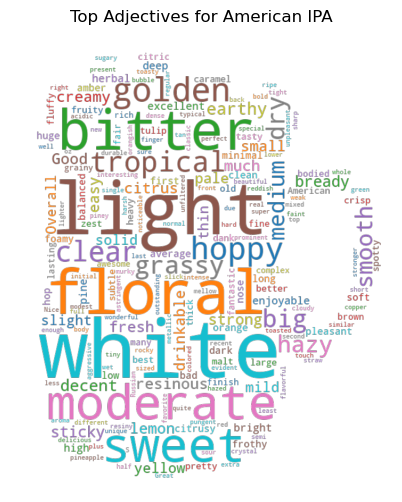

In [314]:
vis_adj_cloud('style','American IPA')

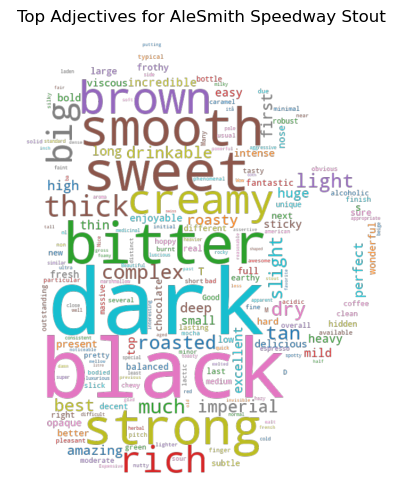

In [315]:
vis_adj_cloud('beer_name','AleSmith Speedway Stout')

In [316]:
# basic recommendation function
def recommendation(method, category, query):
    if method == "region":
        if category == "style":
            styles = regional_analysis[regional_analysis["region"] == query]["popular_styles"].tolist()
            print(f"Popular styles in {query}:", styles)
            for style in styles:
                vis_adj_cloud('style',style)
            return styles
        elif category == "beer_name":
            beers = regional_analysis[regional_analysis["region"] == query]["popular_beers_name"].tolist()
            print(f"Popular beers in {query}:", beers)
            for beer in beers:
                vis_adj_cloud('beer_name',beer)
            return beers
        else:
            raise ValueError("Invalid catogory. Please use 'style' or 'beer_name'.")
    elif method == "keyword":
        if category == "style":
            # return top 3 styles with the keyword
            styles = reviews_per_style[reviews_per_style["keywords"].apply(lambda x: isinstance(x, list) and query in x)]["Modified Style Name"].tolist()
            styles = styles[:3]
            print(f"Popular styles with {query}:", styles)
            for style in styles:
                vis_adj_cloud('style',style)
            return styles
        elif category == "beer_name":
            beers = reviews_per_beer[reviews_per_beer["keywords"].apply(lambda x: isinstance(x, list) and query in x)]["beer_name"].tolist()
            top_3_beers = beers[:3]
            print(f"Top 3 popular beers with {query}:", top_3_beers)
            for beer in top_3_beers:
                vis_adj_cloud('beer_name', beer)
            return top_3_beers
        else:
            raise ValueError("Invalid catogory. Please use 'style' or 'beer_name'.")
    elif method == "similarity":
        if category == "style":
            # determine whether the style is original style or modified style
            if query in reviews_per_style["original_style_name"].tolist():
                styles = reviews_per_style[reviews_per_style["original_style_name"] == query]["top_10_similar_styles"].tolist()[0]
            elif query in reviews_per_style["Modified Style Name"].tolist():
                styles = reviews_per_style[reviews_per_style["Modified Style Name"] == query]["top_10_similar_styles"].tolist()[0]
            else:
                print("Similarity recommendation not available for current style, please try with other styles.")
                return None
            print(f"Similar styles with {query}:", styles)
            styles = styles[:4]
            for style in styles:
                # styles is original style, find the modified style
                if style in reviews_per_style["original_style_name"].tolist():
                    style = reviews_per_style[reviews_per_style["original_style_name"] == style]["Modified Style Name"].tolist()[0]
                else:
                    continue
                vis_adj_cloud('style',style)
            return styles
    else:
        raise ValueError("Invalid method. Currently only support to use 'region' or 'keyword'.")


            

Similar styles with Smoke Porter: ['Bock', 'Belgian Strong Ale', 'Schwarzbier', 'Dry Stout', 'Irish Dry Stout', 'Scotch Ale / Wee Heavy', 'Scotch Ale', 'Munich Helles Lager', 'Heller Bock', 'Altbier']


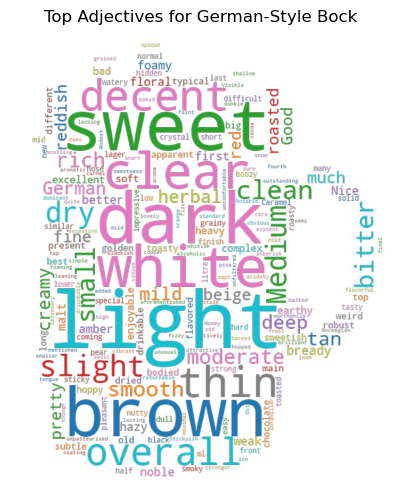

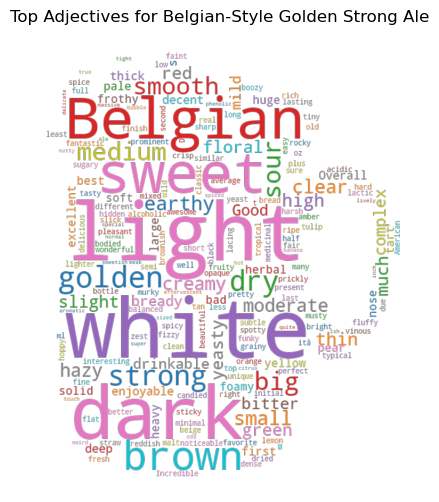

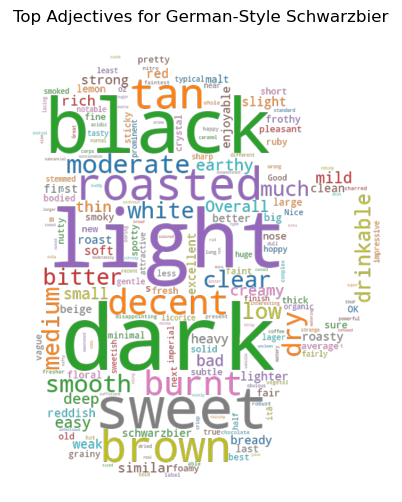

['Bock', 'Belgian Strong Ale', 'Schwarzbier', 'Dry Stout']

In [317]:
recommendation("similarity", "style", "Smoke Porter")

Popular styles in US: ['Classic English-Style Pale Ale', 'Imperial India Pale Ale', 'American Imperial Stout']


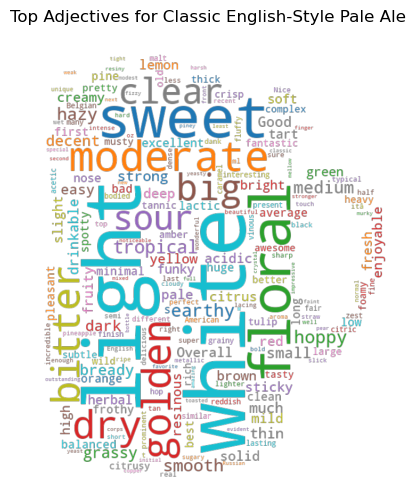

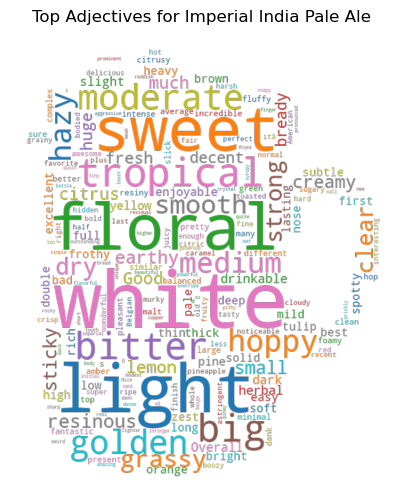

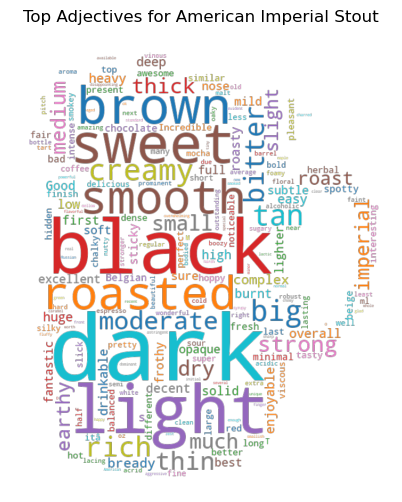

['Classic English-Style Pale Ale',
 'Imperial India Pale Ale',
 'American Imperial Stout']

In [318]:
recommendation("region", "style", "US")



Popular styles with creamy: ['American Imperial Stout', 'American Brown Ale', 'Belgian-Style Quadrupel']


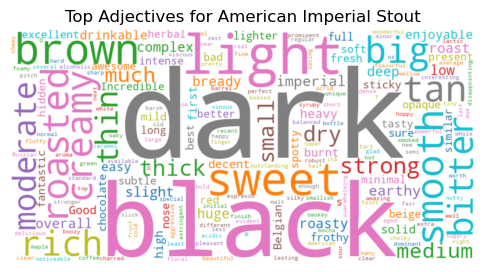

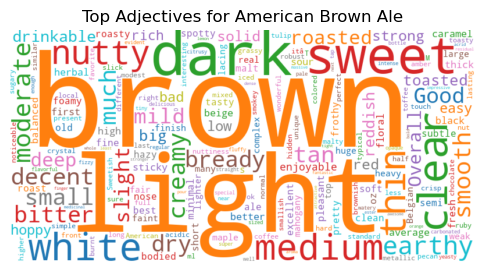

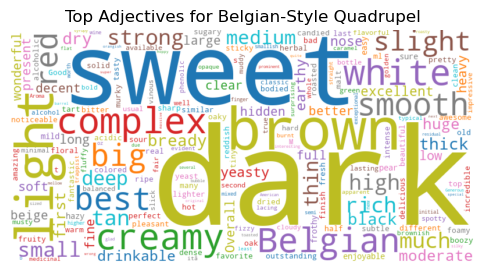

['American Imperial Stout', 'American Brown Ale', 'Belgian-Style Quadrupel']

In [183]:
recommendation("keyword", "style", "creamy")